In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
T=100
dt=1
Boundary=6
signal_noise_ratio = 0.2

In [6]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [7]:
import os.path

if os.path.isfile('examples/dynamical_ball/trajectory.data'):
    trajectory_dict = torch.load('examples/dynamical_ball/trajectory.data')
    STATEs = trajectory_dict['STATEs']
    Disps = trajectory_dict['Disps']
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    trajectory_dict = {
        'STATEs': STATEs,
        'Disps': Disps,
    }
    torch.save(trajectory_dict, 'examples/dynamical_ball/trajectory.data')

In [8]:
def generate_trajectory_trace():
    trajectory = STATEs
    displacements = Disps

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value.cpu().detach()
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value.cpu().detach()
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value.cpu().detach()
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
def generative_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball),
                           lambda: range(T))

In [16]:
def recognition_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return init_bouncing_ball, bouncing_ball_step

In [17]:
def attach_proposals(model, num_particles):
    init_proposal, step_proposal = recognition_model(num_particles)

    init_selector = lambda m: m.name == 'InitBallDynamics'
    init_attach = lambda m: importance.Propose(m, init_proposal)
    model = model.apply(init_attach, init_selector)

    step_selector = lambda m: m.name == 'StepBallDynamics'
    step_attach = lambda m: importance.Propose(m, step_proposal)
    return model.apply(step_attach, step_selector)

In [18]:
def training_model(num_particles, inference_strategy):
    model = generative_model(num_particles)
    model = attach_proposals(model, num_particles)
    return inference_strategy(model)

In [19]:
trajectory, displacements, data = generate_trajectory_trace()

In [20]:
def train_model(num_particles, inference_strategy, bound='elbo', plot_bounds=True, log_estimator=False):
    sampler = training_model(num_particles, inference_strategy)
    
    tau, params, (elbos, eubos) = importance.variational_importance(
        sampler, 500, data, use_cuda=True, lr=1e-1,
        bound=bound, patience=100,
        log_estimator=log_estimator,
    )
    
    if plot_bounds:
        utils.plot_evidence_bounds(elbos.detach().numpy(), True)
        utils.plot_evidence_bounds(eubos.detach().numpy(), False)
    
    return sampler, tau, (elbos, eubos)

In [21]:
def evaluate_inference(sampler, tau):
    inferred_trajectory = accumulate_trajectory(tau)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([tau['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

    graph_original_trajectory(trajectory, T, 0)
    graph_inferred_trajectory(positions, T, 0)
    graph_displacement_trajectories(velocity_steps, displacements, T, 0)
    
    for t in range(T+1):
        logging.info('MSE at time %d: %s' % (t, ((data['position_%d' % t] - positions[t])**2).sum(dim=0)))

In [22]:
sample_sizes = [2, 10, 100]
SAMPLING_STRATEGIES = ['Monte Carlo importance sampling', 'Importance Weighted sampling', 'Sequential Monte Carlo']
sampling_strategies = [(lambda m: m, False), (lambda m: m, True), (lambda m: importance.smc(m), False)]
bounds = ['elbo', 'eubo']

In [23]:
def experiment():
    results = {}
    for i, (inference_strategy, estimator) in enumerate(sampling_strategies):
        for bound in bounds:
            for num_particles in sample_sizes:
                logging.info('Experimenting with sampling strategy: ' + SAMPLING_STRATEGIES[i])
                logging.info('Experimenting with sample size of %d', num_particles)
                logging.info('Experimenting with %s training', 'Wake-Sleep' if bound == 'eubo' else 'Variational')
                sampler, tau, evidence_bounds = train_model((num_particles,), inference_strategy, bound=bound, plot_bounds=True, log_estimator=estimator)
                evaluate_inference(sampler, tau)
                results[(SAMPLING_STRATEGIES[i], num_particles, bound)] = (tau, evidence_bounds)
    return results

03/05/2019 15:08:03 Experimenting with sampling strategy: Monte Carlo importance sampling
03/05/2019 15:08:03 Experimenting with sample size of 2
03/05/2019 15:08:03 Experimenting with Variational training
03/05/2019 15:08:03 ELBO=-1.07237378e+03 at epoch 1
03/05/2019 15:08:03 ELBO=-7.22010742e+02 at epoch 2
03/05/2019 15:08:04 ELBO=-5.12220520e+02 at epoch 3
03/05/2019 15:08:04 ELBO=-6.98204407e+02 at epoch 4
03/05/2019 15:08:04 ELBO=-5.41870972e+02 at epoch 5
03/05/2019 15:08:04 ELBO=-4.92583221e+02 at epoch 6
03/05/2019 15:08:05 ELBO=-5.38951050e+02 at epoch 7
03/05/2019 15:08:05 ELBO=-4.41739044e+02 at epoch 8
03/05/2019 15:08:05 ELBO=-4.37054260e+02 at epoch 9
03/05/2019 15:08:05 ELBO=-5.63840088e+02 at epoch 10
03/05/2019 15:08:05 ELBO=-4.99853943e+02 at epoch 11
03/05/2019 15:08:06 ELBO=-7.37647339e+02 at epoch 12
03/05/2019 15:08:06 ELBO=-4.58672974e+02 at epoch 13
03/05/2019 15:08:06 ELBO=-4.67072021e+02 at epoch 14
03/05/2019 15:08:06 ELBO=-4.33757385e+02 at epoch 15
03/05/20

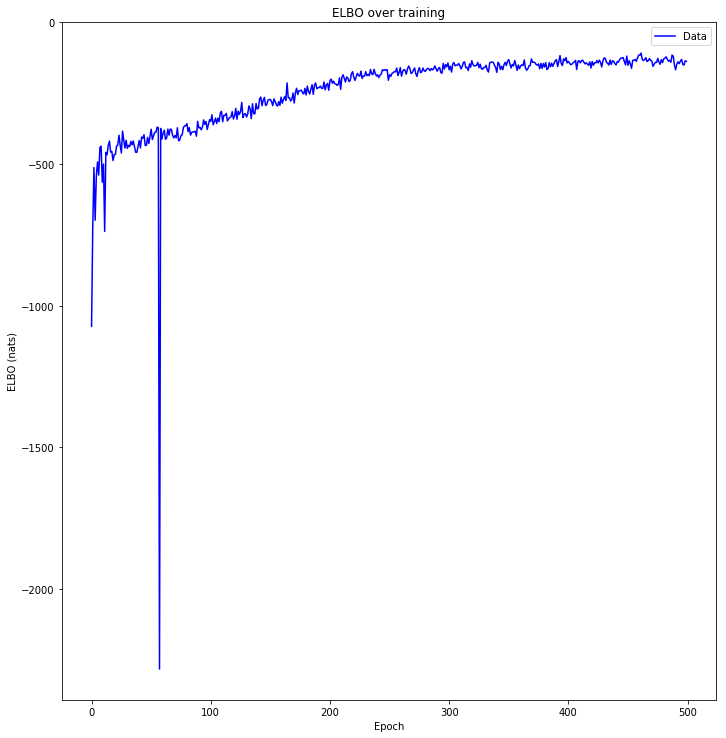

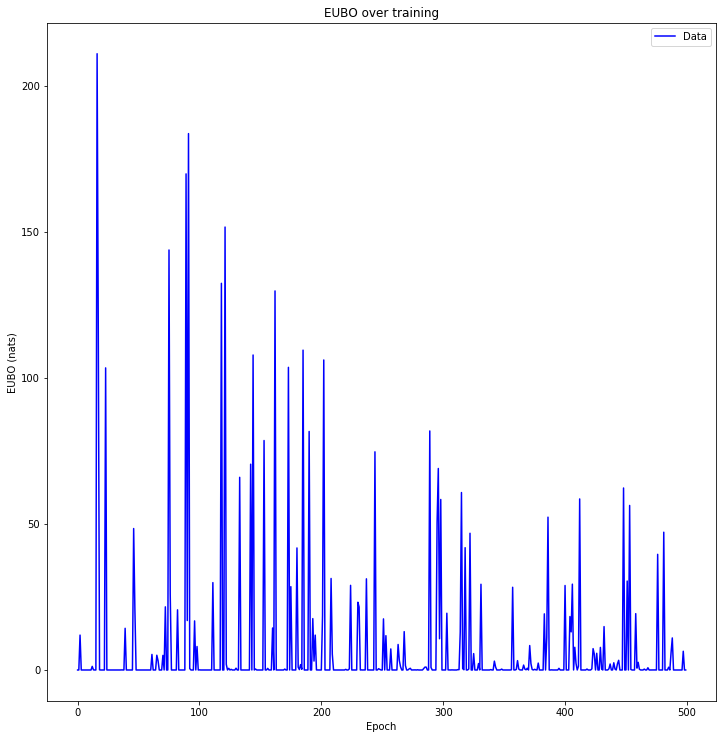

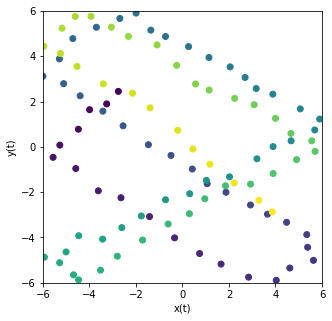

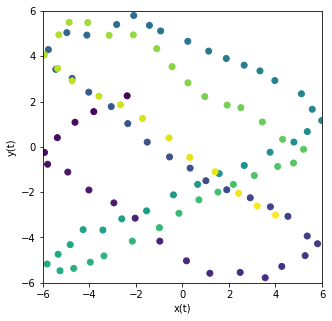

03/05/2019 15:09:43 MSE at time 0: tensor(0.1813)
03/05/2019 15:09:43 MSE at time 1: tensor(0.4232)
03/05/2019 15:09:43 MSE at time 2: tensor(0.7035)
03/05/2019 15:09:43 MSE at time 3: tensor(0.9590)
03/05/2019 15:09:43 MSE at time 4: tensor(0.5392)
03/05/2019 15:09:43 MSE at time 5: tensor(0.1496)
03/05/2019 15:09:43 MSE at time 6: tensor(0.1424)
03/05/2019 15:09:43 MSE at time 7: tensor(0.1640)
03/05/2019 15:09:43 MSE at time 8: tensor(0.1443)
03/05/2019 15:09:43 MSE at time 9: tensor(0.3866)
03/05/2019 15:09:43 MSE at time 10: tensor(0.4240)
03/05/2019 15:09:43 MSE at time 11: tensor(0.4229)
03/05/2019 15:09:43 MSE at time 12: tensor(0.3960)
03/05/2019 15:09:43 MSE at time 13: tensor(0.1752)
03/05/2019 15:09:43 MSE at time 14: tensor(0.2398)
03/05/2019 15:09:43 MSE at time 15: tensor(0.1246)
03/05/2019 15:09:43 MSE at time 16: tensor(0.1703)
03/05/2019 15:09:43 MSE at time 17: tensor(0.2056)
03/05/2019 15:09:43 MSE at time 18: tensor(0.0044)
03/05/2019 15:09:43 MSE at time 19: tenso

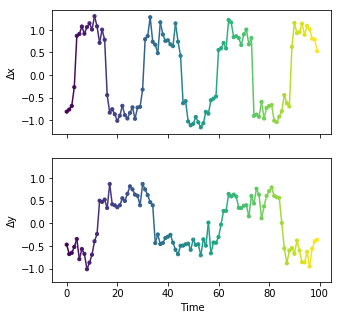

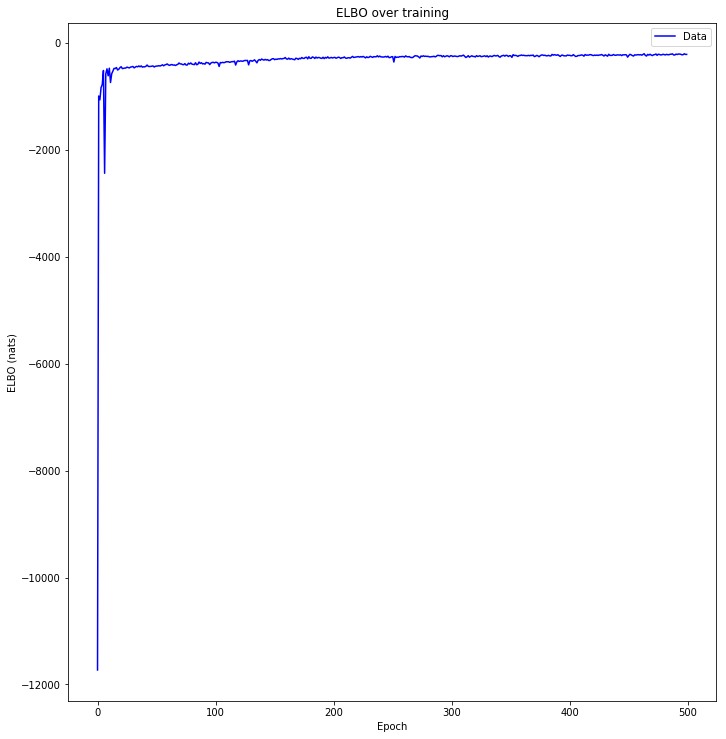

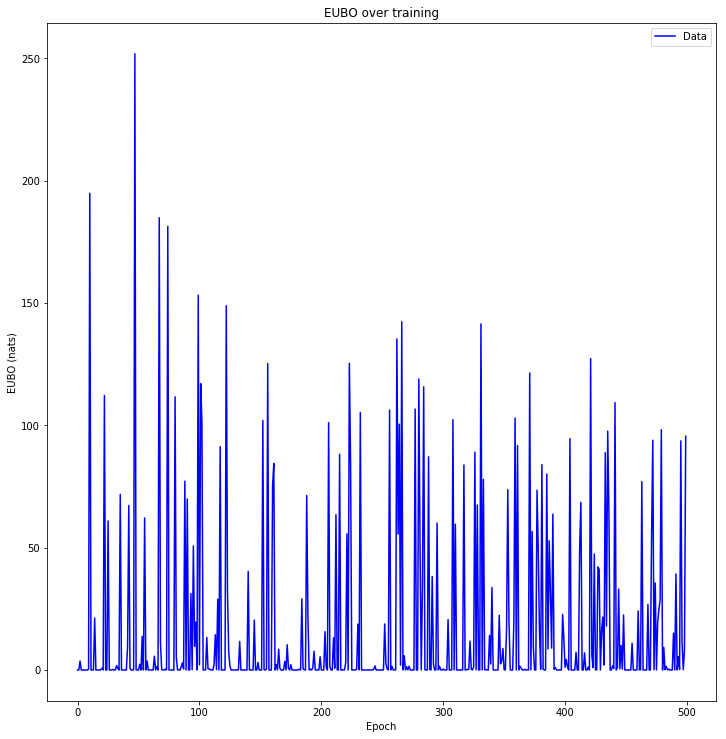

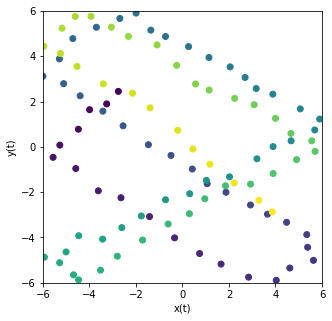

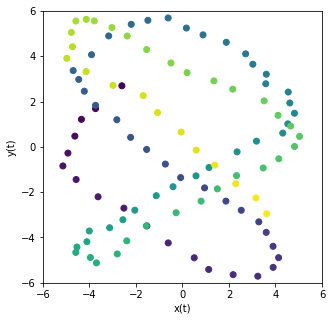

03/05/2019 15:11:25 MSE at time 0: tensor(0.0840)
03/05/2019 15:11:25 MSE at time 1: tensor(0.2731)
03/05/2019 15:11:25 MSE at time 2: tensor(0.3050)
03/05/2019 15:11:25 MSE at time 3: tensor(0.1161)
03/05/2019 15:11:25 MSE at time 4: tensor(0.2440)
03/05/2019 15:11:25 MSE at time 5: tensor(0.3221)
03/05/2019 15:11:25 MSE at time 6: tensor(0.2371)
03/05/2019 15:11:25 MSE at time 7: tensor(0.0697)
03/05/2019 15:11:25 MSE at time 8: tensor(0.2273)
03/05/2019 15:11:25 MSE at time 9: tensor(0.1833)
03/05/2019 15:11:25 MSE at time 10: tensor(0.1247)
03/05/2019 15:11:25 MSE at time 11: tensor(0.0887)
03/05/2019 15:11:25 MSE at time 12: tensor(0.3392)
03/05/2019 15:11:25 MSE at time 13: tensor(0.4534)
03/05/2019 15:11:25 MSE at time 14: tensor(0.6633)
03/05/2019 15:11:25 MSE at time 15: tensor(0.5161)
03/05/2019 15:11:25 MSE at time 16: tensor(2.2587)
03/05/2019 15:11:25 MSE at time 17: tensor(2.2176)
03/05/2019 15:11:25 MSE at time 18: tensor(3.0574)
03/05/2019 15:11:25 MSE at time 19: tenso

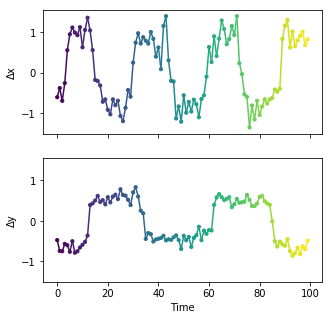

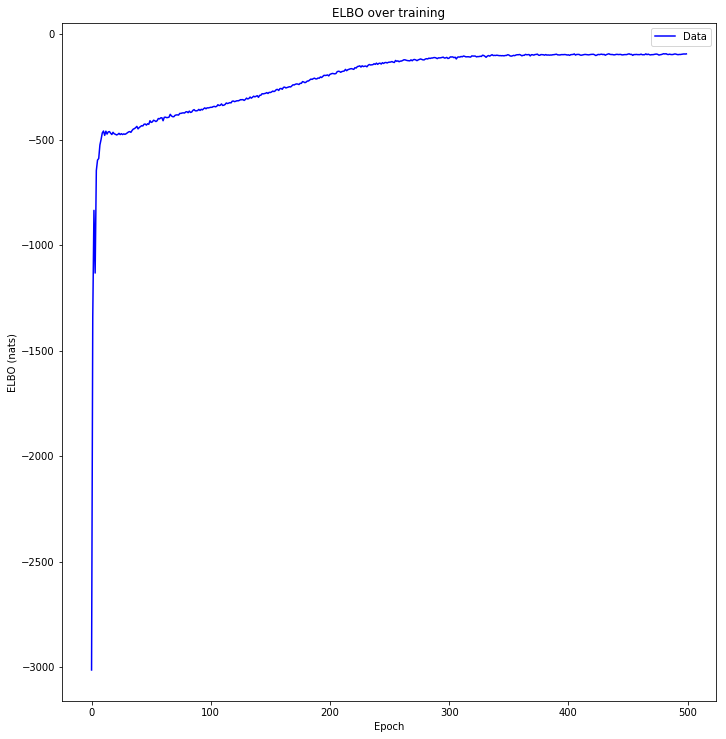

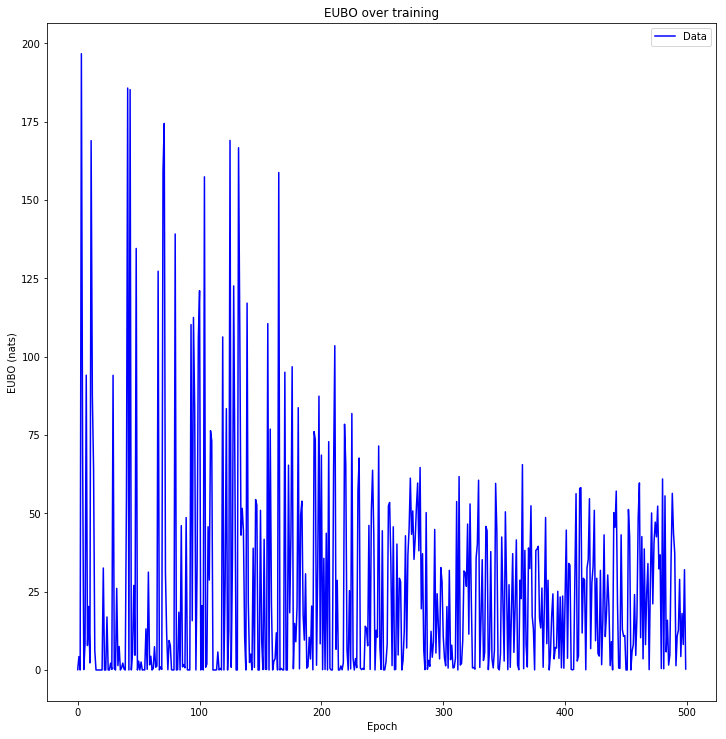

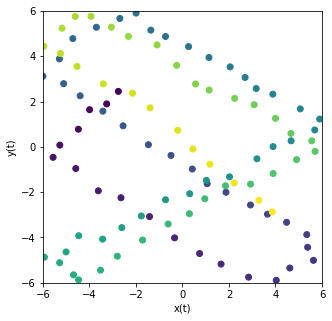

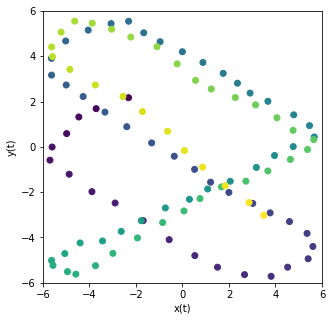

03/05/2019 15:13:11 MSE at time 0: tensor(0.2681)
03/05/2019 15:13:11 MSE at time 1: tensor(0.2483)
03/05/2019 15:13:11 MSE at time 2: tensor(0.3189)
03/05/2019 15:13:11 MSE at time 3: tensor(0.2911)
03/05/2019 15:13:11 MSE at time 4: tensor(0.1177)
03/05/2019 15:13:11 MSE at time 5: tensor(0.0336)
03/05/2019 15:13:11 MSE at time 6: tensor(0.1439)
03/05/2019 15:13:11 MSE at time 7: tensor(0.0764)
03/05/2019 15:13:11 MSE at time 8: tensor(0.1178)
03/05/2019 15:13:11 MSE at time 9: tensor(0.1063)
03/05/2019 15:13:11 MSE at time 10: tensor(0.0605)
03/05/2019 15:13:11 MSE at time 11: tensor(0.0502)
03/05/2019 15:13:11 MSE at time 12: tensor(0.0420)
03/05/2019 15:13:11 MSE at time 13: tensor(0.0423)
03/05/2019 15:13:11 MSE at time 14: tensor(0.0804)
03/05/2019 15:13:11 MSE at time 15: tensor(0.0101)
03/05/2019 15:13:11 MSE at time 16: tensor(0.0566)
03/05/2019 15:13:11 MSE at time 17: tensor(0.0522)
03/05/2019 15:13:11 MSE at time 18: tensor(0.0031)
03/05/2019 15:13:11 MSE at time 19: tenso

Epoch   101: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:13:30 EUBO=-0.00000000e+00 at epoch 104
03/05/2019 15:13:30 EUBO=-0.00000000e+00 at epoch 105
03/05/2019 15:13:31 EUBO=-0.00000000e+00 at epoch 106
03/05/2019 15:13:31 EUBO=1.02093236e-19 at epoch 107
03/05/2019 15:13:31 EUBO=3.56943820e-18 at epoch 108
03/05/2019 15:13:31 EUBO=-0.00000000e+00 at epoch 109
03/05/2019 15:13:31 EUBO=-0.00000000e+00 at epoch 110
03/05/2019 15:13:32 EUBO=3.06043585e-42 at epoch 111
03/05/2019 15:13:32 EUBO=6.96446412e-09 at epoch 112
03/05/2019 15:13:32 EUBO=-0.00000000e+00 at epoch 113
03/05/2019 15:13:32 EUBO=-0.00000000e+00 at epoch 114
03/05/2019 15:13:32 EUBO=-0.00000000e+00 at epoch 115
03/05/2019 15:13:33 EUBO=2.74058705e-12 at epoch 116
03/05/2019 15:13:33 EUBO=-0.00000000e+00 at epoch 117
03/05/2019 15:13:33 EUBO=-0.00000000e+00 at epoch 118
03/05/2019 15:13:33 EUBO=-0.00000000e+00 at epoch 119
03/05/2019 15:13:33 EUBO=-0.00000000e+00 at epoch 120
03/05/2019 15:13:34 EUBO=-0.00000000e+00 at epoch 121
03/05/2019 15:13:34 EUBO=1.179645

Epoch   202: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:13:48 EUBO=3.33300646e-15 at epoch 205
03/05/2019 15:13:49 EUBO=5.35688378e-06 at epoch 206
03/05/2019 15:13:49 EUBO=1.22013921e-27 at epoch 207
03/05/2019 15:13:49 EUBO=1.14407521e-05 at epoch 208
03/05/2019 15:13:49 EUBO=1.22307043e-14 at epoch 209
03/05/2019 15:13:49 EUBO=3.42379208e-05 at epoch 210
03/05/2019 15:13:49 EUBO=1.40542722e+00 at epoch 211
03/05/2019 15:13:50 EUBO=4.47074600e-09 at epoch 212
03/05/2019 15:13:50 EUBO=3.26690733e-01 at epoch 213
03/05/2019 15:13:50 EUBO=2.00985626e+02 at epoch 214
03/05/2019 15:13:50 EUBO=1.02361329e-04 at epoch 215
03/05/2019 15:13:50 EUBO=1.31078878e-07 at epoch 216
03/05/2019 15:13:50 EUBO=3.86936730e-03 at epoch 217
03/05/2019 15:13:51 EUBO=2.16158060e-03 at epoch 218
03/05/2019 15:13:51 EUBO=7.25024912e-13 at epoch 219
03/05/2019 15:13:51 EUBO=4.83806658e-24 at epoch 220
03/05/2019 15:13:51 EUBO=9.11938778e-14 at epoch 221
03/05/2019 15:13:51 EUBO=1.35212440e-11 at epoch 222
03/05/2019 15:13:51 EUBO=1.76138983e-21 at epo

Epoch   303: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 15:14:07 EUBO=1.98485628e-09 at epoch 306
03/05/2019 15:14:07 EUBO=1.42262938e-10 at epoch 307
03/05/2019 15:14:07 EUBO=1.85849686e-07 at epoch 308
03/05/2019 15:14:07 EUBO=2.79817008e-03 at epoch 309
03/05/2019 15:14:08 EUBO=1.63502228e+02 at epoch 310
03/05/2019 15:14:08 EUBO=1.80259363e-08 at epoch 311
03/05/2019 15:14:08 EUBO=4.63037793e-07 at epoch 312
03/05/2019 15:14:08 EUBO=3.10818401e-13 at epoch 313
03/05/2019 15:14:08 EUBO=1.89223925e-07 at epoch 314
03/05/2019 15:14:08 EUBO=3.30506325e-08 at epoch 315
03/05/2019 15:14:09 EUBO=1.74209976e+02 at epoch 316
03/05/2019 15:14:09 EUBO=9.08312378e+01 at epoch 317
03/05/2019 15:14:09 EUBO=1.55616999e+00 at epoch 318
03/05/2019 15:14:09 EUBO=1.48306034e-09 at epoch 319
03/05/2019 15:14:09 EUBO=6.31731898e-02 at epoch 320
03/05/2019 15:14:10 EUBO=1.73154053e+02 at epoch 321
03/05/2019 15:14:10 EUBO=1.75476909e-01 at epoch 322
03/05/2019 15:14:10 EUBO=6.72363788e-02 at epoch 323
03/05/2019 15:14:10 EUBO=6.67656021e+01 at epo

Epoch   404: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 15:14:26 EUBO=4.77933426e+01 at epoch 407
03/05/2019 15:14:26 EUBO=4.36437085e-06 at epoch 408
03/05/2019 15:14:26 EUBO=6.52471542e-36 at epoch 409
03/05/2019 15:14:26 EUBO=2.42229173e-04 at epoch 410
03/05/2019 15:14:26 EUBO=1.96707876e-11 at epoch 411
03/05/2019 15:14:27 EUBO=1.28042939e-06 at epoch 412
03/05/2019 15:14:27 EUBO=4.75331321e-02 at epoch 413
03/05/2019 15:14:27 EUBO=1.11457642e-10 at epoch 414
03/05/2019 15:14:27 EUBO=1.82870845e-03 at epoch 415
03/05/2019 15:14:27 EUBO=3.43396289e-17 at epoch 416
03/05/2019 15:14:27 EUBO=1.49787399e+02 at epoch 417
03/05/2019 15:14:28 EUBO=1.25775238e+02 at epoch 418
03/05/2019 15:14:28 EUBO=2.24966596e-22 at epoch 419
03/05/2019 15:14:28 EUBO=2.67783706e-14 at epoch 420
03/05/2019 15:14:28 EUBO=6.54471283e+01 at epoch 421
03/05/2019 15:14:28 EUBO=6.15525429e-33 at epoch 422
03/05/2019 15:14:29 EUBO=3.09478843e-08 at epoch 423
03/05/2019 15:14:29 EUBO=6.07358402e-07 at epoch 424
03/05/2019 15:14:29 EUBO=1.61228403e-02 at epo

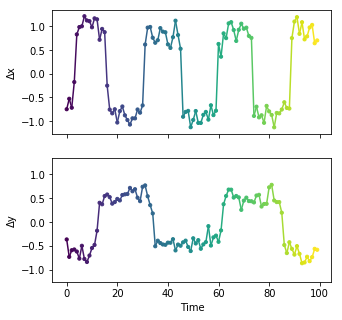

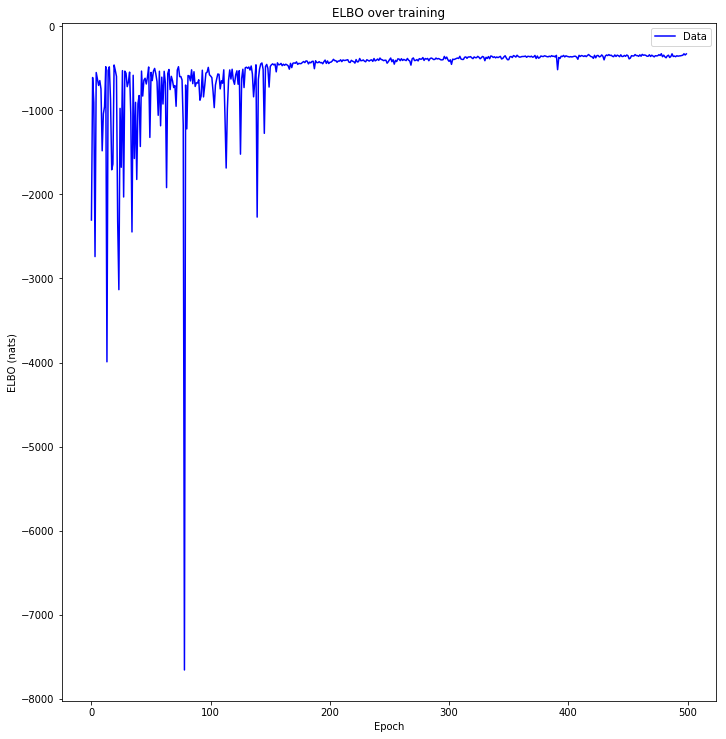

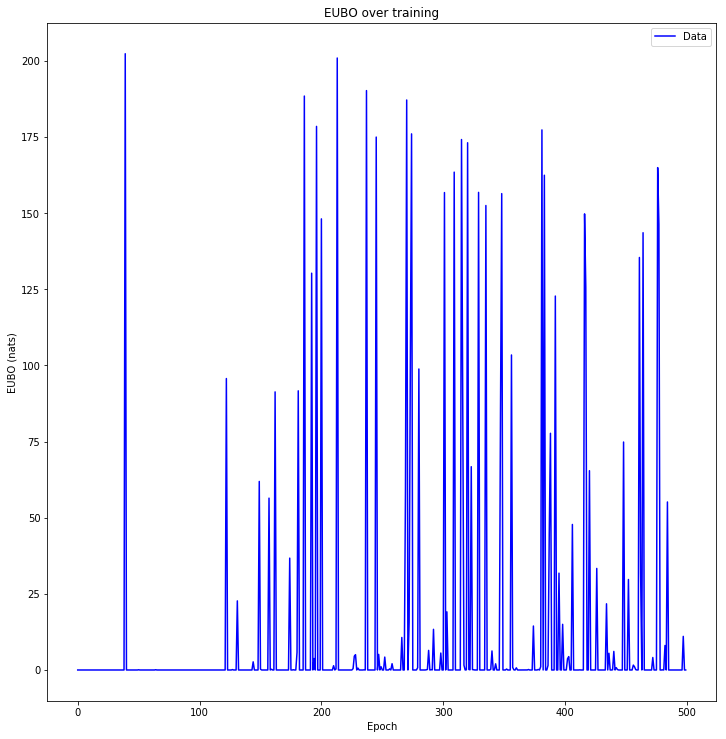

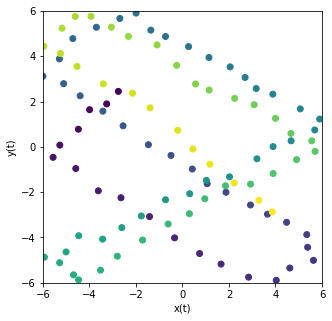

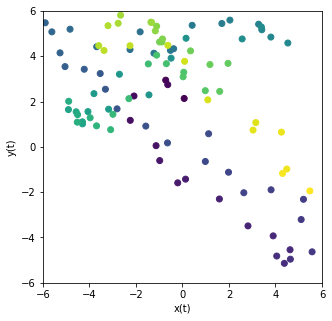

03/05/2019 15:14:43 MSE at time 0: tensor(8.1131)
03/05/2019 15:14:43 MSE at time 1: tensor(7.5419)
03/05/2019 15:14:43 MSE at time 2: tensor(12.5122)
03/05/2019 15:14:43 MSE at time 3: tensor(7.8755)
03/05/2019 15:14:43 MSE at time 4: tensor(10.3757)
03/05/2019 15:14:43 MSE at time 5: tensor(19.8797)
03/05/2019 15:14:43 MSE at time 6: tensor(13.1616)
03/05/2019 15:14:43 MSE at time 7: tensor(11.7956)
03/05/2019 15:14:43 MSE at time 8: tensor(8.3857)
03/05/2019 15:14:43 MSE at time 9: tensor(9.6315)
03/05/2019 15:14:43 MSE at time 10: tensor(10.2426)
03/05/2019 15:14:43 MSE at time 11: tensor(10.6239)
03/05/2019 15:14:43 MSE at time 12: tensor(9.2042)
03/05/2019 15:14:43 MSE at time 13: tensor(2.7369)
03/05/2019 15:14:43 MSE at time 14: tensor(1.1482)
03/05/2019 15:14:43 MSE at time 15: tensor(0.1527)
03/05/2019 15:14:43 MSE at time 16: tensor(0.1446)
03/05/2019 15:14:43 MSE at time 17: tensor(1.5774)
03/05/2019 15:14:43 MSE at time 18: tensor(2.4494)
03/05/2019 15:14:43 MSE at time 19

Epoch   101: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:15:02 EUBO=1.78218597e+02 at epoch 104
03/05/2019 15:15:02 EUBO=2.06897690e+02 at epoch 105
03/05/2019 15:15:03 EUBO=5.60127501e-06 at epoch 106
03/05/2019 15:15:03 EUBO=1.15352783e+02 at epoch 107
03/05/2019 15:15:03 EUBO=8.07480365e-02 at epoch 108
03/05/2019 15:15:03 EUBO=2.98581386e+00 at epoch 109
03/05/2019 15:15:03 EUBO=6.95953140e+01 at epoch 110
03/05/2019 15:15:03 EUBO=6.23615837e+00 at epoch 111
03/05/2019 15:15:04 EUBO=5.28825040e-04 at epoch 112
03/05/2019 15:15:04 EUBO=1.07454471e-05 at epoch 113
03/05/2019 15:15:04 EUBO=5.29657528e-02 at epoch 114
03/05/2019 15:15:04 EUBO=8.55742677e-09 at epoch 115
03/05/2019 15:15:04 EUBO=5.04505234e+01 at epoch 116
03/05/2019 15:15:04 EUBO=3.10366631e+01 at epoch 117
03/05/2019 15:15:05 EUBO=5.10755479e-02 at epoch 118
03/05/2019 15:15:05 EUBO=8.98361874e+00 at epoch 119
03/05/2019 15:15:05 EUBO=7.49764023e+01 at epoch 120
03/05/2019 15:15:05 EUBO=2.87902243e-02 at epoch 121
03/05/2019 15:15:05 EUBO=8.33314362e+01 at epo

Epoch   202: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:15:20 EUBO=2.03728723e-09 at epoch 205
03/05/2019 15:15:20 EUBO=6.27839342e-02 at epoch 206
03/05/2019 15:15:20 EUBO=1.04427025e+02 at epoch 207
03/05/2019 15:15:21 EUBO=1.19102612e+01 at epoch 208
03/05/2019 15:15:21 EUBO=2.15900674e-01 at epoch 209
03/05/2019 15:15:21 EUBO=6.97553396e-01 at epoch 210
03/05/2019 15:15:21 EUBO=7.44380093e+00 at epoch 211
03/05/2019 15:15:21 EUBO=1.19142456e+01 at epoch 212
03/05/2019 15:15:21 EUBO=1.48790379e+01 at epoch 213
03/05/2019 15:15:22 EUBO=4.11254387e+01 at epoch 214
03/05/2019 15:15:22 EUBO=2.37477088e-05 at epoch 215
03/05/2019 15:15:22 EUBO=3.99331093e+01 at epoch 216
03/05/2019 15:15:22 EUBO=9.29189911e+01 at epoch 217
03/05/2019 15:15:22 EUBO=5.16319752e+00 at epoch 218
03/05/2019 15:15:22 EUBO=2.76106322e-04 at epoch 219
03/05/2019 15:15:23 EUBO=2.12334995e+01 at epoch 220
03/05/2019 15:15:23 EUBO=1.19016804e-02 at epoch 221
03/05/2019 15:15:23 EUBO=9.74124527e+00 at epoch 222
03/05/2019 15:15:23 EUBO=5.92764525e-04 at epo

Epoch   303: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 15:15:39 EUBO=7.65229687e-02 at epoch 306
03/05/2019 15:15:39 EUBO=3.90455093e+01 at epoch 307
03/05/2019 15:15:40 EUBO=2.54117432e+01 at epoch 308
03/05/2019 15:15:40 EUBO=5.98499086e-04 at epoch 309
03/05/2019 15:15:40 EUBO=8.82388878e+00 at epoch 310
03/05/2019 15:15:40 EUBO=3.99538986e-02 at epoch 311
03/05/2019 15:15:40 EUBO=4.04215736e+01 at epoch 312
03/05/2019 15:15:41 EUBO=1.90086868e-02 at epoch 313
03/05/2019 15:15:41 EUBO=3.81804891e-02 at epoch 314
03/05/2019 15:15:41 EUBO=8.22572503e-04 at epoch 315
03/05/2019 15:15:41 EUBO=1.36106433e-02 at epoch 316
03/05/2019 15:15:41 EUBO=3.89227034e-06 at epoch 317
03/05/2019 15:15:42 EUBO=1.86079788e+01 at epoch 318
03/05/2019 15:15:42 EUBO=1.50041103e+01 at epoch 319
03/05/2019 15:15:42 EUBO=9.86613110e-02 at epoch 320
03/05/2019 15:15:42 EUBO=6.43249178e+00 at epoch 321
03/05/2019 15:15:42 EUBO=1.31640089e+00 at epoch 322
03/05/2019 15:15:42 EUBO=6.21388931e+01 at epoch 323
03/05/2019 15:15:43 EUBO=2.22627754e+01 at epo

Epoch   404: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 15:15:58 EUBO=4.94476350e-04 at epoch 407
03/05/2019 15:15:58 EUBO=2.16353778e-02 at epoch 408
03/05/2019 15:15:58 EUBO=2.67987896e-04 at epoch 409
03/05/2019 15:15:58 EUBO=6.67471027e+00 at epoch 410
03/05/2019 15:15:59 EUBO=4.02411156e+01 at epoch 411
03/05/2019 15:15:59 EUBO=2.53605270e+01 at epoch 412
03/05/2019 15:15:59 EUBO=4.51303989e-01 at epoch 413
03/05/2019 15:15:59 EUBO=1.20482273e+01 at epoch 414
03/05/2019 15:15:59 EUBO=7.30374336e-01 at epoch 415
03/05/2019 15:16:00 EUBO=7.79363632e+01 at epoch 416
03/05/2019 15:16:00 EUBO=1.79255829e+01 at epoch 417
03/05/2019 15:16:00 EUBO=8.88507657e-06 at epoch 418
03/05/2019 15:16:00 EUBO=3.03336972e-04 at epoch 419
03/05/2019 15:16:00 EUBO=1.79938012e-04 at epoch 420
03/05/2019 15:16:00 EUBO=6.15318527e+01 at epoch 421
03/05/2019 15:16:01 EUBO=4.28710505e-03 at epoch 422
03/05/2019 15:16:01 EUBO=8.72914124e+00 at epoch 423
03/05/2019 15:16:01 EUBO=4.68203468e+01 at epoch 424
03/05/2019 15:16:01 EUBO=1.11934519e+00 at epo

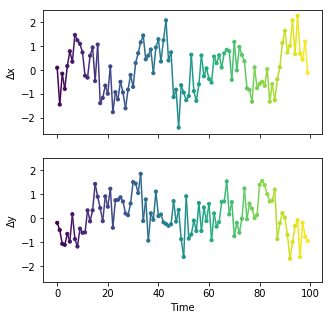

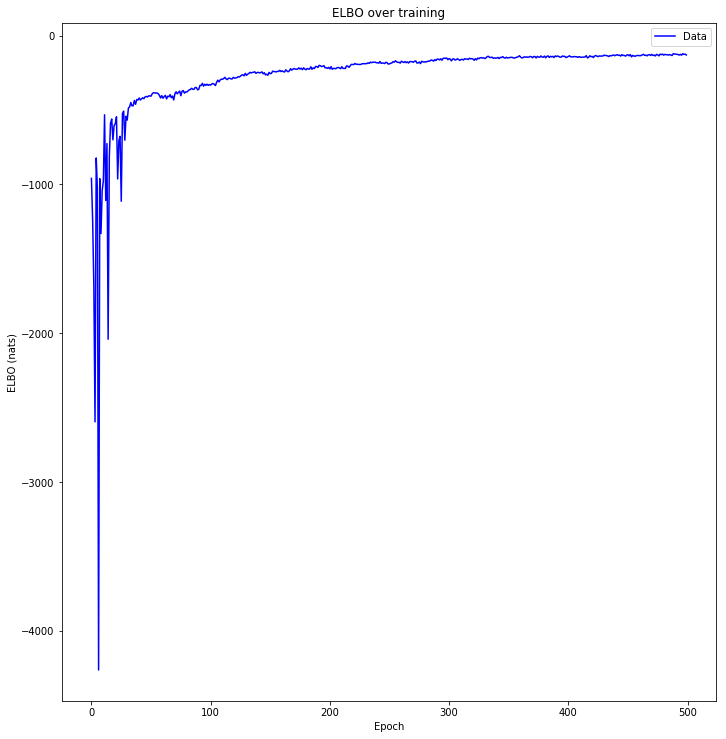

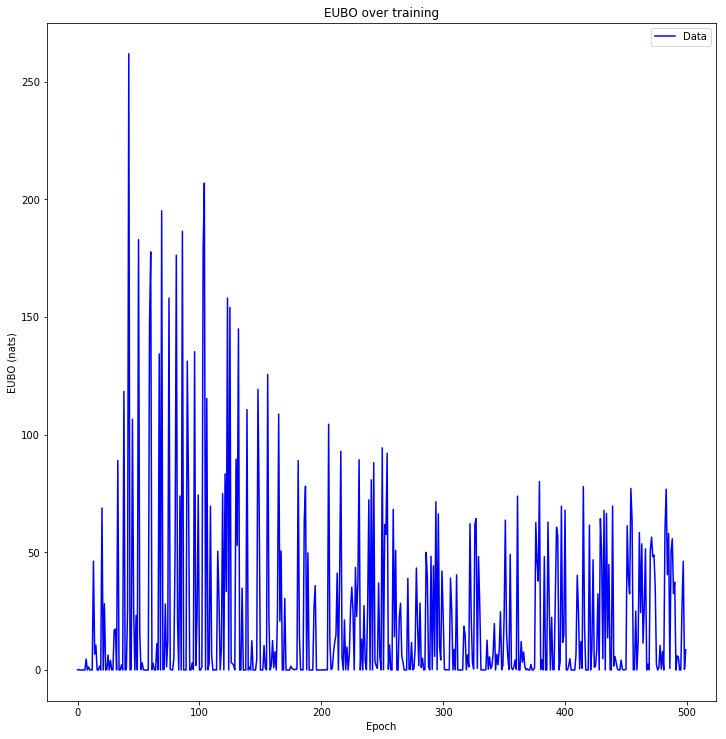

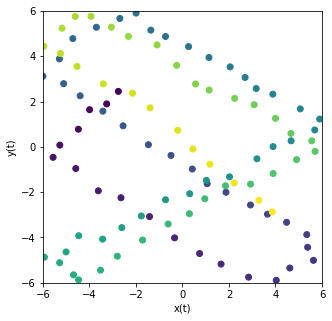

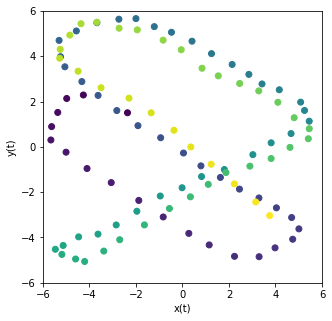

03/05/2019 15:16:16 MSE at time 0: tensor(1.0473)
03/05/2019 15:16:16 MSE at time 1: tensor(1.1610)
03/05/2019 15:16:16 MSE at time 2: tensor(1.2124)
03/05/2019 15:16:16 MSE at time 3: tensor(1.3360)
03/05/2019 15:16:16 MSE at time 4: tensor(0.7930)
03/05/2019 15:16:16 MSE at time 5: tensor(0.5951)
03/05/2019 15:16:16 MSE at time 6: tensor(0.6941)
03/05/2019 15:16:16 MSE at time 7: tensor(1.2043)
03/05/2019 15:16:16 MSE at time 8: tensor(0.6220)
03/05/2019 15:16:16 MSE at time 9: tensor(0.7222)
03/05/2019 15:16:16 MSE at time 10: tensor(1.0903)
03/05/2019 15:16:16 MSE at time 11: tensor(1.0053)
03/05/2019 15:16:16 MSE at time 12: tensor(0.9778)
03/05/2019 15:16:16 MSE at time 13: tensor(1.2090)
03/05/2019 15:16:16 MSE at time 14: tensor(1.6319)
03/05/2019 15:16:16 MSE at time 15: tensor(1.1959)
03/05/2019 15:16:16 MSE at time 16: tensor(1.6644)
03/05/2019 15:16:16 MSE at time 17: tensor(0.8020)
03/05/2019 15:16:16 MSE at time 18: tensor(0.9922)
03/05/2019 15:16:16 MSE at time 19: tenso

Epoch   123: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:16:41 EUBO=7.65304983e-01 at epoch 126
03/05/2019 15:16:42 EUBO=1.71132088e+01 at epoch 127
03/05/2019 15:16:42 EUBO=7.11247940e+01 at epoch 128
03/05/2019 15:16:42 EUBO=5.60857697e+01 at epoch 129
03/05/2019 15:16:42 EUBO=8.94533545e-02 at epoch 130
03/05/2019 15:16:42 EUBO=1.45293980e+01 at epoch 131
03/05/2019 15:16:43 EUBO=8.37928876e-02 at epoch 132
03/05/2019 15:16:43 EUBO=1.29022705e+02 at epoch 133
03/05/2019 15:16:43 EUBO=1.32476270e-01 at epoch 134
03/05/2019 15:16:43 EUBO=8.74882936e-01 at epoch 135
03/05/2019 15:16:43 EUBO=4.67003416e-03 at epoch 136
03/05/2019 15:16:44 EUBO=8.01854312e-01 at epoch 137
03/05/2019 15:16:44 EUBO=8.15785646e-01 at epoch 138
03/05/2019 15:16:44 EUBO=6.61118774e+01 at epoch 139
03/05/2019 15:16:44 EUBO=3.46644402e-01 at epoch 140
03/05/2019 15:16:44 EUBO=1.33625465e-02 at epoch 141
03/05/2019 15:16:45 EUBO=4.90256405e+00 at epoch 142
03/05/2019 15:16:45 EUBO=2.43259144e+00 at epoch 143
03/05/2019 15:16:45 EUBO=7.85929908e-04 at epo

Epoch   224: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:17:02 EUBO=1.07077095e+02 at epoch 227
03/05/2019 15:17:02 EUBO=1.39096823e+01 at epoch 228
03/05/2019 15:17:03 EUBO=8.49353943e+01 at epoch 229
03/05/2019 15:17:03 EUBO=6.61656342e+01 at epoch 230
03/05/2019 15:17:03 EUBO=1.00739431e+01 at epoch 231
03/05/2019 15:17:03 EUBO=1.92721978e-01 at epoch 232
03/05/2019 15:17:03 EUBO=6.58487167e+01 at epoch 233
03/05/2019 15:17:04 EUBO=6.30482368e+01 at epoch 234
03/05/2019 15:17:04 EUBO=9.22851334e+01 at epoch 235
03/05/2019 15:17:04 EUBO=4.96041794e+01 at epoch 236
03/05/2019 15:17:04 EUBO=2.92100582e+01 at epoch 237
03/05/2019 15:17:05 EUBO=1.86497936e+01 at epoch 238
03/05/2019 15:17:05 EUBO=1.01653412e+02 at epoch 239
03/05/2019 15:17:05 EUBO=1.45875779e-03 at epoch 240
03/05/2019 15:17:05 EUBO=6.09186962e-02 at epoch 241
03/05/2019 15:17:06 EUBO=3.09765979e-04 at epoch 242
03/05/2019 15:17:06 EUBO=1.15023413e+01 at epoch 243
03/05/2019 15:17:06 EUBO=5.65946960e+01 at epoch 244
03/05/2019 15:17:06 EUBO=4.16675377e+01 at epo

Epoch   325: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 15:17:23 EUBO=4.41039085e+01 at epoch 328
03/05/2019 15:17:24 EUBO=6.88763335e-02 at epoch 329
03/05/2019 15:17:24 EUBO=3.06505132e+00 at epoch 330
03/05/2019 15:17:24 EUBO=1.69836683e-03 at epoch 331
03/05/2019 15:17:24 EUBO=3.06015372e-01 at epoch 332
03/05/2019 15:17:24 EUBO=4.76773453e+00 at epoch 333
03/05/2019 15:17:25 EUBO=6.29763119e-03 at epoch 334
03/05/2019 15:17:25 EUBO=7.23337250e+01 at epoch 335
03/05/2019 15:17:25 EUBO=2.93866992e+00 at epoch 336
03/05/2019 15:17:25 EUBO=3.54718494e+00 at epoch 337
03/05/2019 15:17:25 EUBO=5.13762512e+01 at epoch 338
03/05/2019 15:17:26 EUBO=5.48713951e+01 at epoch 339
03/05/2019 15:17:26 EUBO=5.96418686e+01 at epoch 340
03/05/2019 15:17:26 EUBO=2.85951410e-05 at epoch 341
03/05/2019 15:17:26 EUBO=6.71107340e+00 at epoch 342
03/05/2019 15:17:26 EUBO=5.84501953e+01 at epoch 343
03/05/2019 15:17:27 EUBO=3.79213638e+01 at epoch 344
03/05/2019 15:17:27 EUBO=8.28777850e-02 at epoch 345
03/05/2019 15:17:27 EUBO=3.23858070e+01 at epo

Epoch   426: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 15:17:44 EUBO=6.16399311e-02 at epoch 429
03/05/2019 15:17:44 EUBO=6.20353239e-05 at epoch 430
03/05/2019 15:17:45 EUBO=1.02787600e+01 at epoch 431
03/05/2019 15:17:45 EUBO=3.51531601e+01 at epoch 432
03/05/2019 15:17:45 EUBO=6.01982117e+00 at epoch 433
03/05/2019 15:17:45 EUBO=5.31836557e+00 at epoch 434
03/05/2019 15:17:45 EUBO=5.05623169e+01 at epoch 435
03/05/2019 15:17:46 EUBO=4.16238880e+00 at epoch 436
03/05/2019 15:17:46 EUBO=3.72508202e+01 at epoch 437
03/05/2019 15:17:46 EUBO=2.42912370e-06 at epoch 438
03/05/2019 15:17:46 EUBO=2.65520973e+01 at epoch 439
03/05/2019 15:17:47 EUBO=2.32125874e+01 at epoch 440
03/05/2019 15:17:47 EUBO=2.44808388e+01 at epoch 441
03/05/2019 15:17:47 EUBO=1.37951088e+01 at epoch 442
03/05/2019 15:17:47 EUBO=5.77997856e+01 at epoch 443
03/05/2019 15:17:47 EUBO=9.98843098e+00 at epoch 444
03/05/2019 15:17:48 EUBO=3.32977219e+01 at epoch 445
03/05/2019 15:17:48 EUBO=6.23057222e+00 at epoch 446
03/05/2019 15:17:48 EUBO=2.27891933e-03 at epo

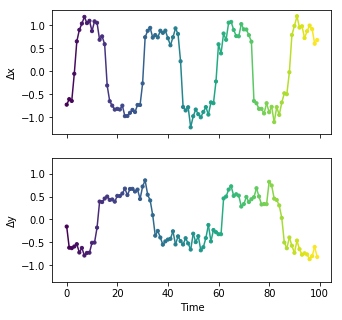

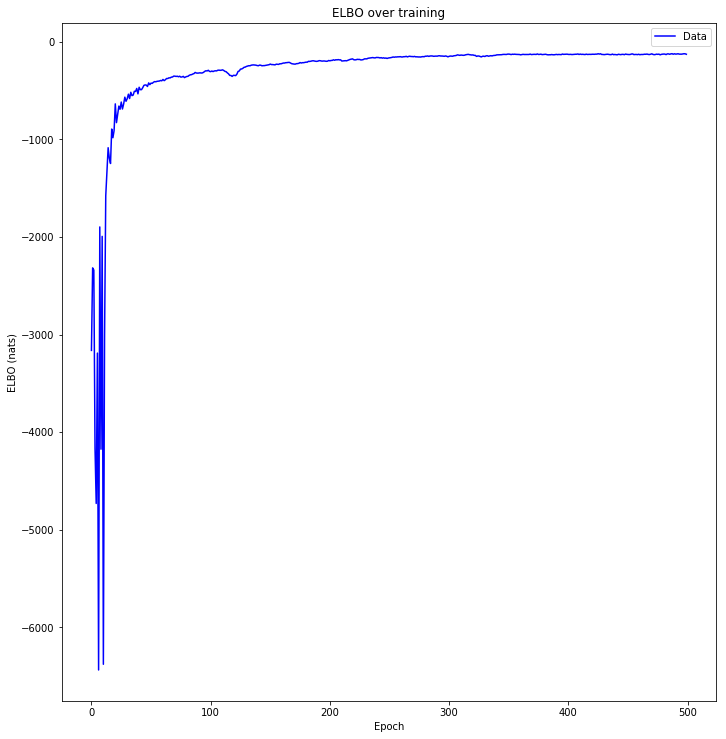

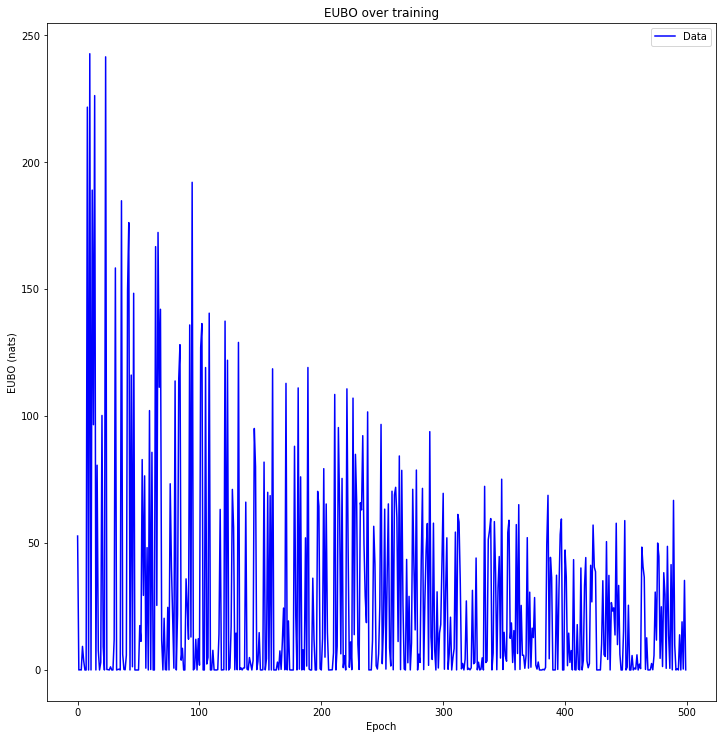

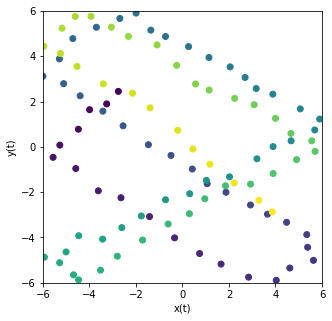

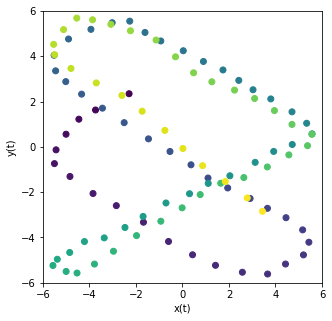

03/05/2019 15:17:59 MSE at time 0: tensor(0.2232)
03/05/2019 15:17:59 MSE at time 1: tensor(0.3022)
03/05/2019 15:17:59 MSE at time 2: tensor(0.3896)
03/05/2019 15:17:59 MSE at time 3: tensor(0.3303)
03/05/2019 15:17:59 MSE at time 4: tensor(0.0696)
03/05/2019 15:17:59 MSE at time 5: tensor(0.0808)
03/05/2019 15:17:59 MSE at time 6: tensor(0.1858)
03/05/2019 15:17:59 MSE at time 7: tensor(0.0657)
03/05/2019 15:17:59 MSE at time 8: tensor(0.1623)
03/05/2019 15:17:59 MSE at time 9: tensor(0.1300)
03/05/2019 15:17:59 MSE at time 10: tensor(0.0933)
03/05/2019 15:17:59 MSE at time 11: tensor(0.0950)
03/05/2019 15:17:59 MSE at time 12: tensor(0.0604)
03/05/2019 15:17:59 MSE at time 13: tensor(0.1179)
03/05/2019 15:17:59 MSE at time 14: tensor(0.2162)
03/05/2019 15:17:59 MSE at time 15: tensor(0.0657)
03/05/2019 15:17:59 MSE at time 16: tensor(0.2419)
03/05/2019 15:17:59 MSE at time 17: tensor(0.0524)
03/05/2019 15:17:59 MSE at time 18: tensor(0.0753)
03/05/2019 15:17:59 MSE at time 19: tenso

Epoch   452: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:19:28 ELBO=-1.74056137e+02 at epoch 455
03/05/2019 15:19:28 ELBO=-1.39723175e+02 at epoch 456
03/05/2019 15:19:28 ELBO=-1.55223969e+02 at epoch 457
03/05/2019 15:19:28 ELBO=-1.16604340e+02 at epoch 458
03/05/2019 15:19:28 ELBO=-1.31370346e+02 at epoch 459
03/05/2019 15:19:29 ELBO=-1.44028656e+02 at epoch 460
03/05/2019 15:19:29 ELBO=-1.34473587e+02 at epoch 461
03/05/2019 15:19:29 ELBO=-8.81958008e+01 at epoch 462
03/05/2019 15:19:29 ELBO=-1.40589478e+02 at epoch 463
03/05/2019 15:19:30 ELBO=-1.40656342e+02 at epoch 464
03/05/2019 15:19:30 ELBO=-1.35324814e+02 at epoch 465
03/05/2019 15:19:30 ELBO=-1.54166153e+02 at epoch 466
03/05/2019 15:19:30 ELBO=-1.45117676e+02 at epoch 467
03/05/2019 15:19:30 ELBO=-9.95163345e+01 at epoch 468
03/05/2019 15:19:31 ELBO=-1.17402069e+02 at epoch 469
03/05/2019 15:19:31 ELBO=-1.45229385e+02 at epoch 470
03/05/2019 15:19:31 ELBO=-1.45661194e+02 at epoch 471
03/05/2019 15:19:31 ELBO=-1.49487381e+02 at epoch 472
03/05/2019 15:19:31 ELBO=-1.

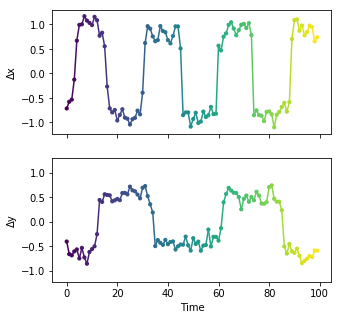

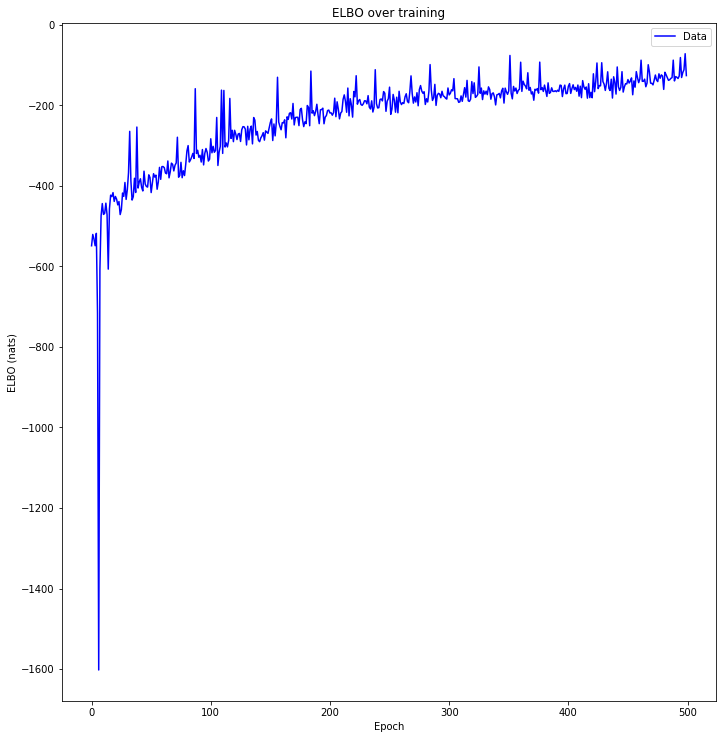

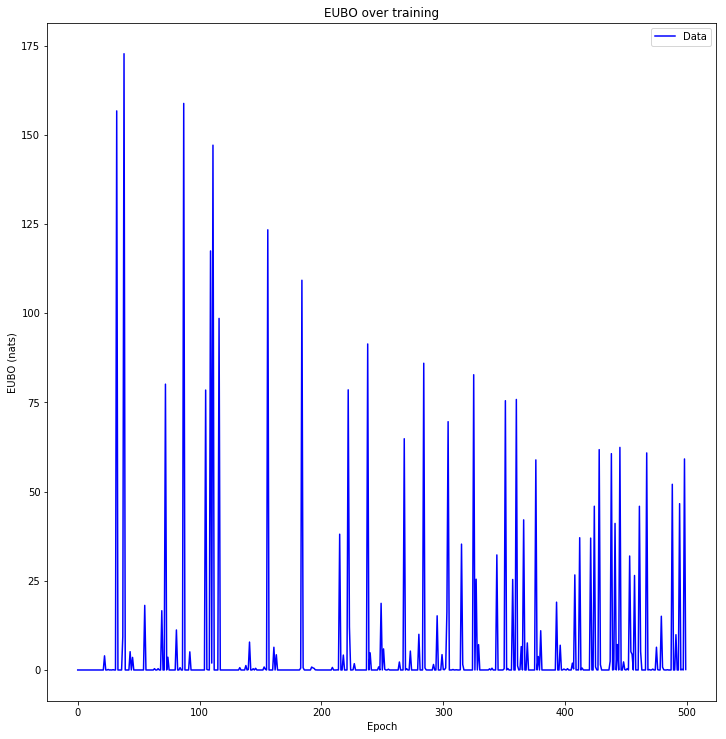

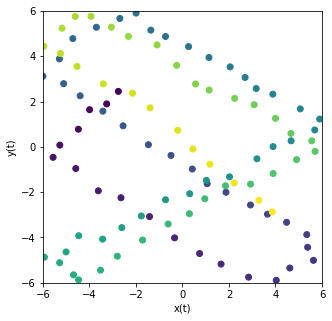

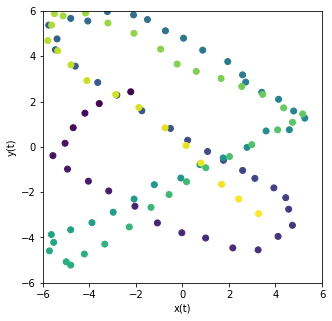

03/05/2019 15:19:37 MSE at time 0: tensor(0.2848)
03/05/2019 15:19:37 MSE at time 1: tensor(0.1023)
03/05/2019 15:19:37 MSE at time 2: tensor(0.0642)
03/05/2019 15:19:37 MSE at time 3: tensor(0.0538)
03/05/2019 15:19:37 MSE at time 4: tensor(0.0570)
03/05/2019 15:19:37 MSE at time 5: tensor(0.0055)
03/05/2019 15:19:37 MSE at time 6: tensor(0.1268)
03/05/2019 15:19:37 MSE at time 7: tensor(0.3620)
03/05/2019 15:19:37 MSE at time 8: tensor(0.3672)
03/05/2019 15:19:37 MSE at time 9: tensor(0.6029)
03/05/2019 15:19:37 MSE at time 10: tensor(0.9811)
03/05/2019 15:19:37 MSE at time 11: tensor(1.4230)
03/05/2019 15:19:37 MSE at time 12: tensor(1.7662)
03/05/2019 15:19:37 MSE at time 13: tensor(2.1248)
03/05/2019 15:19:37 MSE at time 14: tensor(2.4155)
03/05/2019 15:19:37 MSE at time 15: tensor(2.2042)
03/05/2019 15:19:37 MSE at time 16: tensor(3.2129)
03/05/2019 15:19:37 MSE at time 17: tensor(3.4901)
03/05/2019 15:19:37 MSE at time 18: tensor(3.4790)
03/05/2019 15:19:37 MSE at time 19: tenso

Epoch   409: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:21:01 ELBO=-1.43883713e+02 at epoch 412
03/05/2019 15:21:01 ELBO=-1.39953415e+02 at epoch 413
03/05/2019 15:21:01 ELBO=-1.51609726e+02 at epoch 414
03/05/2019 15:21:01 ELBO=-1.44512543e+02 at epoch 415
03/05/2019 15:21:02 ELBO=-1.40304962e+02 at epoch 416
03/05/2019 15:21:02 ELBO=-1.25703880e+02 at epoch 417
03/05/2019 15:21:02 ELBO=-1.04664680e+02 at epoch 418
03/05/2019 15:21:02 ELBO=-1.32132690e+02 at epoch 419
03/05/2019 15:21:02 ELBO=-7.46483154e+01 at epoch 420
03/05/2019 15:21:03 ELBO=-1.19883949e+02 at epoch 421
03/05/2019 15:21:03 ELBO=-1.22001709e+02 at epoch 422
03/05/2019 15:21:03 ELBO=-1.25153641e+02 at epoch 423
03/05/2019 15:21:03 ELBO=-1.21366600e+02 at epoch 424
03/05/2019 15:21:03 ELBO=-5.28223991e+01 at epoch 425
03/05/2019 15:21:04 ELBO=-1.14831688e+02 at epoch 426
03/05/2019 15:21:04 ELBO=-1.17704407e+02 at epoch 427
03/05/2019 15:21:04 ELBO=-1.25521950e+02 at epoch 428
03/05/2019 15:21:04 ELBO=-1.12777573e+02 at epoch 429
03/05/2019 15:21:04 ELBO=-1.

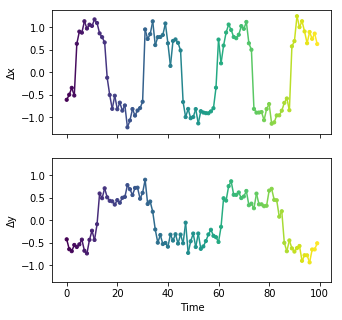

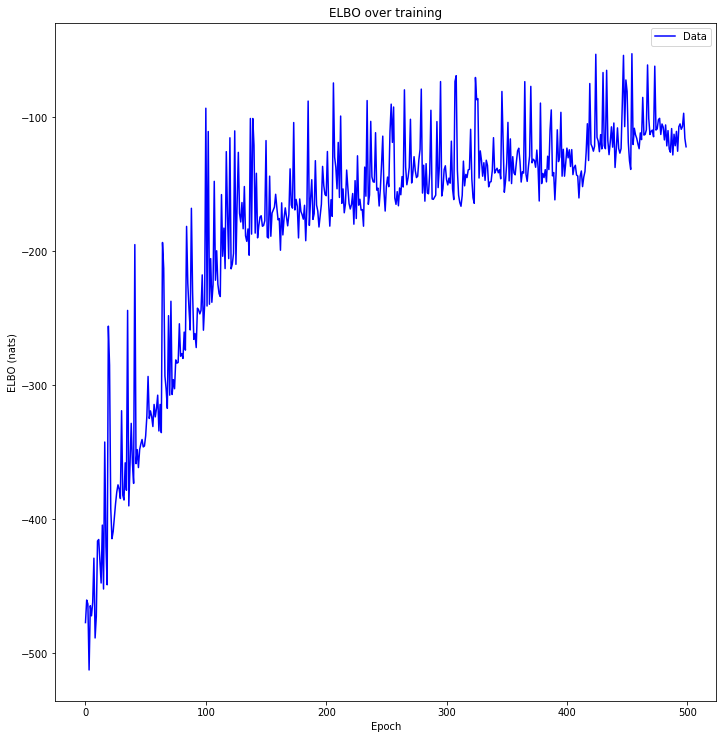

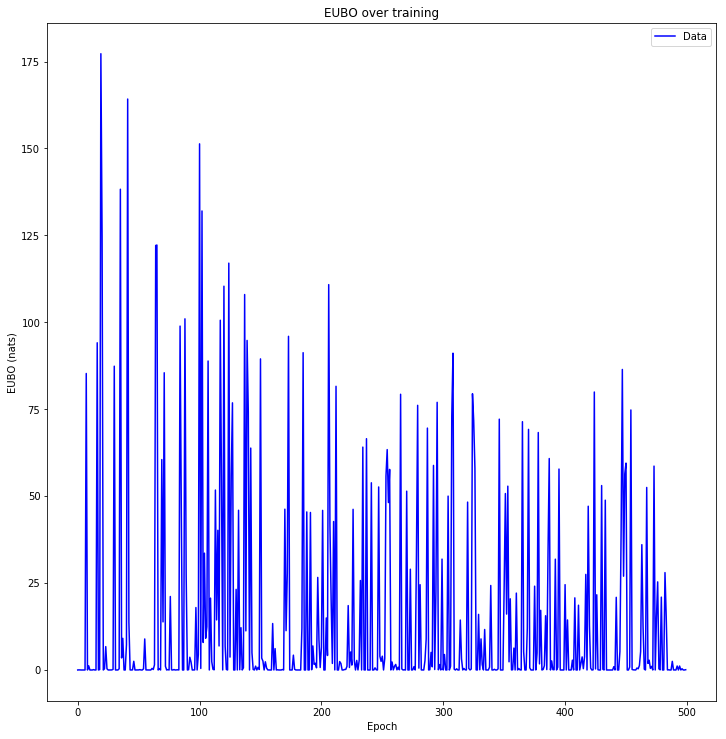

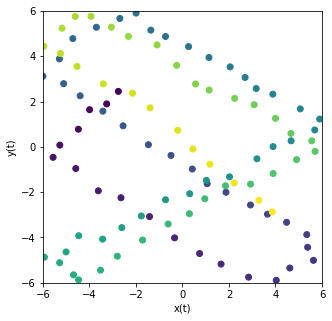

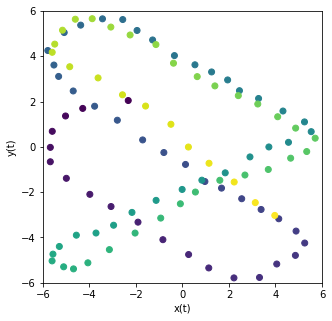

03/05/2019 15:21:20 MSE at time 0: tensor(0.3433)
03/05/2019 15:21:20 MSE at time 1: tensor(1.1018)
03/05/2019 15:21:20 MSE at time 2: tensor(1.1495)
03/05/2019 15:21:20 MSE at time 3: tensor(1.2694)
03/05/2019 15:21:20 MSE at time 4: tensor(0.1770)
03/05/2019 15:21:20 MSE at time 5: tensor(0.0531)
03/05/2019 15:21:20 MSE at time 6: tensor(0.3515)
03/05/2019 15:21:20 MSE at time 7: tensor(0.1568)
03/05/2019 15:21:20 MSE at time 8: tensor(0.3334)
03/05/2019 15:21:20 MSE at time 9: tensor(0.3067)
03/05/2019 15:21:20 MSE at time 10: tensor(0.2590)
03/05/2019 15:21:20 MSE at time 11: tensor(0.2255)
03/05/2019 15:21:20 MSE at time 12: tensor(0.3090)
03/05/2019 15:21:20 MSE at time 13: tensor(0.3971)
03/05/2019 15:21:20 MSE at time 14: tensor(0.5357)
03/05/2019 15:21:20 MSE at time 15: tensor(0.3471)
03/05/2019 15:21:20 MSE at time 16: tensor(0.6498)
03/05/2019 15:21:20 MSE at time 17: tensor(0.0511)
03/05/2019 15:21:20 MSE at time 18: tensor(0.2370)
03/05/2019 15:21:20 MSE at time 19: tenso

Epoch   441: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:22:50 ELBO=-1.32168213e+02 at epoch 444
03/05/2019 15:22:50 ELBO=-1.03380981e+02 at epoch 445
03/05/2019 15:22:50 ELBO=-1.22796692e+02 at epoch 446
03/05/2019 15:22:50 ELBO=-1.29577621e+02 at epoch 447
03/05/2019 15:22:51 ELBO=-8.42115784e+01 at epoch 448
03/05/2019 15:22:51 ELBO=-7.63648148e+01 at epoch 449
03/05/2019 15:22:51 ELBO=-1.16940773e+02 at epoch 450
03/05/2019 15:22:51 ELBO=-1.16580902e+02 at epoch 451
03/05/2019 15:22:51 ELBO=-1.09682632e+02 at epoch 452
03/05/2019 15:22:52 ELBO=-1.05238724e+02 at epoch 453
03/05/2019 15:22:52 ELBO=-1.11570824e+02 at epoch 454
03/05/2019 15:22:52 ELBO=-9.68960495e+01 at epoch 455
03/05/2019 15:22:52 ELBO=-9.82299347e+01 at epoch 456
03/05/2019 15:22:52 ELBO=-1.02769226e+02 at epoch 457
03/05/2019 15:22:53 ELBO=-1.08165245e+02 at epoch 458
03/05/2019 15:22:53 ELBO=-1.06479172e+02 at epoch 459
03/05/2019 15:22:53 ELBO=-1.02240677e+02 at epoch 460
03/05/2019 15:22:53 ELBO=-5.97177658e+01 at epoch 461
03/05/2019 15:22:53 ELBO=-4.

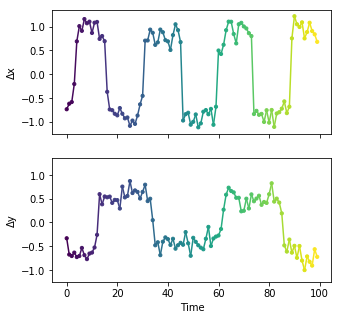

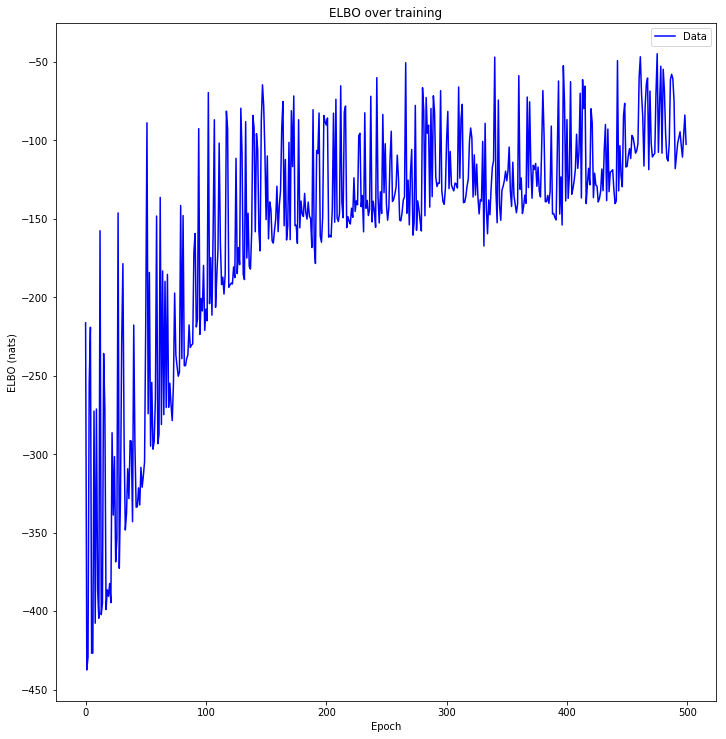

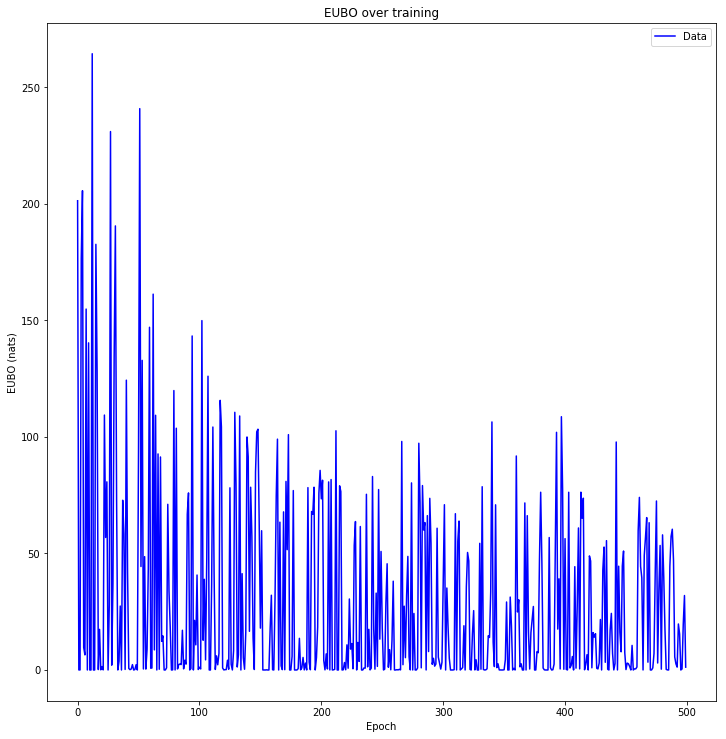

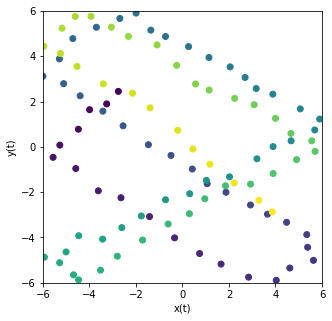

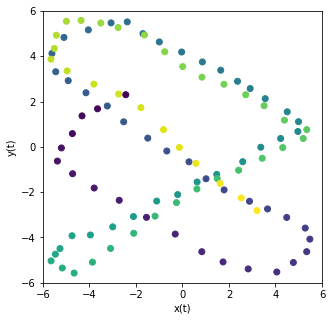

03/05/2019 15:23:01 MSE at time 0: tensor(0.1233)
03/05/2019 15:23:01 MSE at time 1: tensor(0.2018)
03/05/2019 15:23:01 MSE at time 2: tensor(0.1808)
03/05/2019 15:23:01 MSE at time 3: tensor(0.1040)
03/05/2019 15:23:01 MSE at time 4: tensor(0.0197)
03/05/2019 15:23:01 MSE at time 5: tensor(0.0621)
03/05/2019 15:23:01 MSE at time 6: tensor(0.0720)
03/05/2019 15:23:01 MSE at time 7: tensor(0.0468)
03/05/2019 15:23:01 MSE at time 8: tensor(0.0183)
03/05/2019 15:23:01 MSE at time 9: tensor(0.0183)
03/05/2019 15:23:01 MSE at time 10: tensor(0.0287)
03/05/2019 15:23:01 MSE at time 11: tensor(0.0157)
03/05/2019 15:23:01 MSE at time 12: tensor(0.0164)
03/05/2019 15:23:01 MSE at time 13: tensor(0.1307)
03/05/2019 15:23:01 MSE at time 14: tensor(0.1351)
03/05/2019 15:23:01 MSE at time 15: tensor(0.0832)
03/05/2019 15:23:01 MSE at time 16: tensor(0.2304)
03/05/2019 15:23:01 MSE at time 17: tensor(0.1379)
03/05/2019 15:23:01 MSE at time 18: tensor(0.0877)
03/05/2019 15:23:01 MSE at time 19: tenso

Epoch   101: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:23:18 EUBO=-0.00000000e+00 at epoch 104
03/05/2019 15:23:18 EUBO=-0.00000000e+00 at epoch 105
03/05/2019 15:23:18 EUBO=-0.00000000e+00 at epoch 106
03/05/2019 15:23:19 EUBO=-0.00000000e+00 at epoch 107
03/05/2019 15:23:19 EUBO=1.28051269e-27 at epoch 108
03/05/2019 15:23:19 EUBO=-0.00000000e+00 at epoch 109
03/05/2019 15:23:19 EUBO=-0.00000000e+00 at epoch 110
03/05/2019 15:23:19 EUBO=-0.00000000e+00 at epoch 111
03/05/2019 15:23:19 EUBO=-0.00000000e+00 at epoch 112
03/05/2019 15:23:20 EUBO=-0.00000000e+00 at epoch 113
03/05/2019 15:23:20 EUBO=-0.00000000e+00 at epoch 114
03/05/2019 15:23:20 EUBO=-0.00000000e+00 at epoch 115
03/05/2019 15:23:20 EUBO=-0.00000000e+00 at epoch 116
03/05/2019 15:23:20 EUBO=-0.00000000e+00 at epoch 117
03/05/2019 15:23:20 EUBO=3.11040527e-10 at epoch 118
03/05/2019 15:23:21 EUBO=-0.00000000e+00 at epoch 119
03/05/2019 15:23:21 EUBO=-0.00000000e+00 at epoch 120
03/05/2019 15:23:21 EUBO=-0.00000000e+00 at epoch 121
03/05/2019 15:23:21 EUBO=1.874

Epoch   202: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:23:35 EUBO=-0.00000000e+00 at epoch 205
03/05/2019 15:23:35 EUBO=-0.00000000e+00 at epoch 206
03/05/2019 15:23:35 EUBO=4.37035197e-26 at epoch 207
03/05/2019 15:23:36 EUBO=-0.00000000e+00 at epoch 208
03/05/2019 15:23:36 EUBO=-0.00000000e+00 at epoch 209
03/05/2019 15:23:36 EUBO=-0.00000000e+00 at epoch 210
03/05/2019 15:23:36 EUBO=-0.00000000e+00 at epoch 211
03/05/2019 15:23:36 EUBO=-0.00000000e+00 at epoch 212
03/05/2019 15:23:36 EUBO=-0.00000000e+00 at epoch 213
03/05/2019 15:23:37 EUBO=-0.00000000e+00 at epoch 214
03/05/2019 15:23:37 EUBO=-0.00000000e+00 at epoch 215
03/05/2019 15:23:37 EUBO=-0.00000000e+00 at epoch 216
03/05/2019 15:23:37 EUBO=-0.00000000e+00 at epoch 217
03/05/2019 15:23:37 EUBO=-0.00000000e+00 at epoch 218
03/05/2019 15:23:37 EUBO=-0.00000000e+00 at epoch 219
03/05/2019 15:23:38 EUBO=-0.00000000e+00 at epoch 220
03/05/2019 15:23:38 EUBO=-0.00000000e+00 at epoch 221
03/05/2019 15:23:38 EUBO=-0.00000000e+00 at epoch 222
03/05/2019 15:23:38 EUBO=-0.0

Epoch   303: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 15:23:52 EUBO=-0.00000000e+00 at epoch 306
03/05/2019 15:23:52 EUBO=2.79825567e-33 at epoch 307
03/05/2019 15:23:53 EUBO=-0.00000000e+00 at epoch 308
03/05/2019 15:23:53 EUBO=1.77087692e-40 at epoch 309
03/05/2019 15:23:53 EUBO=-0.00000000e+00 at epoch 310
03/05/2019 15:23:53 EUBO=-0.00000000e+00 at epoch 311
03/05/2019 15:23:53 EUBO=-0.00000000e+00 at epoch 312
03/05/2019 15:23:53 EUBO=-0.00000000e+00 at epoch 313
03/05/2019 15:23:53 EUBO=2.65044864e-33 at epoch 314
03/05/2019 15:23:54 EUBO=-0.00000000e+00 at epoch 315
03/05/2019 15:23:54 EUBO=-0.00000000e+00 at epoch 316
03/05/2019 15:23:54 EUBO=-0.00000000e+00 at epoch 317
03/05/2019 15:23:54 EUBO=-0.00000000e+00 at epoch 318
03/05/2019 15:23:54 EUBO=-0.00000000e+00 at epoch 319
03/05/2019 15:23:54 EUBO=-0.00000000e+00 at epoch 320
03/05/2019 15:23:55 EUBO=-0.00000000e+00 at epoch 321
03/05/2019 15:23:55 EUBO=9.10347201e-22 at epoch 322
03/05/2019 15:23:55 EUBO=-0.00000000e+00 at epoch 323
03/05/2019 15:23:55 EUBO=-0.0000

Epoch   404: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 15:24:09 EUBO=-0.00000000e+00 at epoch 407
03/05/2019 15:24:09 EUBO=-0.00000000e+00 at epoch 408
03/05/2019 15:24:10 EUBO=-0.00000000e+00 at epoch 409
03/05/2019 15:24:10 EUBO=-0.00000000e+00 at epoch 410
03/05/2019 15:24:10 EUBO=1.36830056e-34 at epoch 411
03/05/2019 15:24:10 EUBO=-0.00000000e+00 at epoch 412
03/05/2019 15:24:10 EUBO=-0.00000000e+00 at epoch 413
03/05/2019 15:24:10 EUBO=-0.00000000e+00 at epoch 414
03/05/2019 15:24:11 EUBO=-0.00000000e+00 at epoch 415
03/05/2019 15:24:11 EUBO=-0.00000000e+00 at epoch 416
03/05/2019 15:24:11 EUBO=-0.00000000e+00 at epoch 417
03/05/2019 15:24:11 EUBO=-0.00000000e+00 at epoch 418
03/05/2019 15:24:11 EUBO=-0.00000000e+00 at epoch 419
03/05/2019 15:24:11 EUBO=-0.00000000e+00 at epoch 420
03/05/2019 15:24:12 EUBO=-0.00000000e+00 at epoch 421
03/05/2019 15:24:12 EUBO=-0.00000000e+00 at epoch 422
03/05/2019 15:24:12 EUBO=-0.00000000e+00 at epoch 423
03/05/2019 15:24:12 EUBO=-0.00000000e+00 at epoch 424
03/05/2019 15:24:12 EUBO=9.44

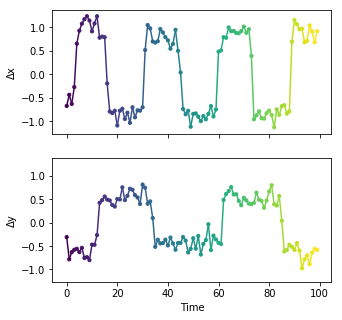

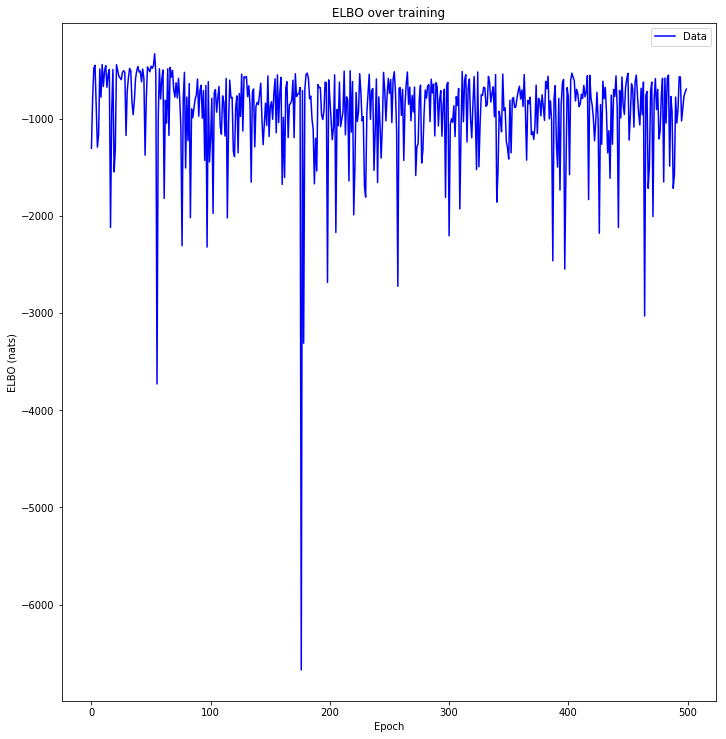

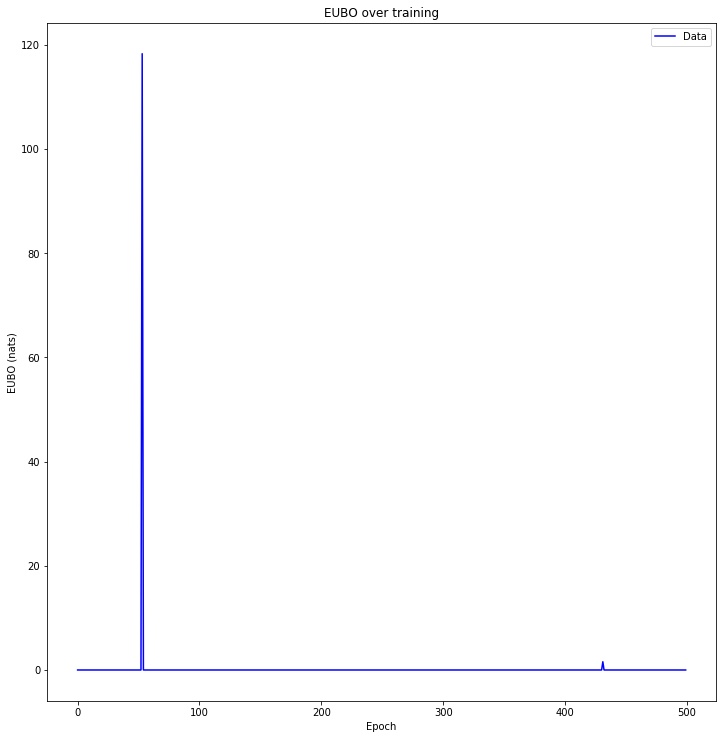

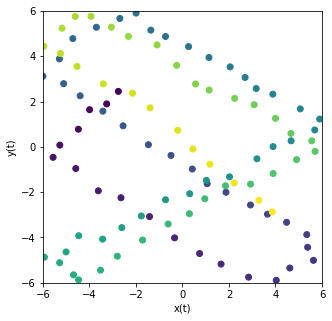

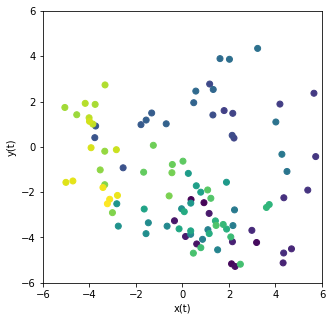

03/05/2019 15:24:25 MSE at time 0: tensor(32.5928)
03/05/2019 15:24:25 MSE at time 1: tensor(36.5252)
03/05/2019 15:24:25 MSE at time 2: tensor(83.5881)
03/05/2019 15:24:25 MSE at time 3: tensor(83.7640)
03/05/2019 15:24:25 MSE at time 4: tensor(85.4877)
03/05/2019 15:24:25 MSE at time 5: tensor(52.7754)
03/05/2019 15:24:25 MSE at time 6: tensor(23.3445)
03/05/2019 15:24:25 MSE at time 7: tensor(23.7097)
03/05/2019 15:24:25 MSE at time 8: tensor(10.6348)
03/05/2019 15:24:25 MSE at time 9: tensor(13.9462)
03/05/2019 15:24:25 MSE at time 10: tensor(23.0099)
03/05/2019 15:24:25 MSE at time 11: tensor(15.6643)
03/05/2019 15:24:25 MSE at time 12: tensor(3.9747)
03/05/2019 15:24:25 MSE at time 13: tensor(3.4097)
03/05/2019 15:24:25 MSE at time 14: tensor(13.3885)
03/05/2019 15:24:25 MSE at time 15: tensor(12.4311)
03/05/2019 15:24:25 MSE at time 16: tensor(20.9960)
03/05/2019 15:24:25 MSE at time 17: tensor(46.3171)
03/05/2019 15:24:25 MSE at time 18: tensor(34.5421)
03/05/2019 15:24:25 MSE 

Epoch   112: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:24:44 EUBO=1.50934764e-04 at epoch 115
03/05/2019 15:24:44 EUBO=6.11497569e-07 at epoch 116
03/05/2019 15:24:44 EUBO=8.42910524e-08 at epoch 117
03/05/2019 15:24:44 EUBO=5.41471443e+01 at epoch 118
03/05/2019 15:24:45 EUBO=2.10679919e-02 at epoch 119
03/05/2019 15:24:45 EUBO=1.36392426e-08 at epoch 120
03/05/2019 15:24:45 EUBO=1.08635568e-05 at epoch 121
03/05/2019 15:24:45 EUBO=1.88938343e-15 at epoch 122
03/05/2019 15:24:45 EUBO=2.92250297e-06 at epoch 123
03/05/2019 15:24:45 EUBO=6.56047287e+01 at epoch 124
03/05/2019 15:24:46 EUBO=5.25295944e+01 at epoch 125
03/05/2019 15:24:46 EUBO=4.29679276e-05 at epoch 126
03/05/2019 15:24:46 EUBO=2.69961905e+00 at epoch 127
03/05/2019 15:24:46 EUBO=3.05491335e-06 at epoch 128
03/05/2019 15:24:46 EUBO=1.39726486e+02 at epoch 129
03/05/2019 15:24:46 EUBO=1.04408874e-03 at epoch 130
03/05/2019 15:24:47 EUBO=1.51050836e-01 at epoch 131
03/05/2019 15:24:47 EUBO=2.20990814e-02 at epoch 132
03/05/2019 15:24:47 EUBO=2.03281626e-01 at epo

Epoch   213: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:25:00 EUBO=2.18092129e-02 at epoch 216
03/05/2019 15:25:00 EUBO=1.15621805e+00 at epoch 217
03/05/2019 15:25:00 EUBO=2.86048940e-09 at epoch 218
03/05/2019 15:25:01 EUBO=7.97871552e+01 at epoch 219
03/05/2019 15:25:01 EUBO=9.08634661e-07 at epoch 220
03/05/2019 15:25:01 EUBO=2.15293723e-04 at epoch 221
03/05/2019 15:25:01 EUBO=1.14755676e+02 at epoch 222
03/05/2019 15:25:01 EUBO=1.89252358e-04 at epoch 223
03/05/2019 15:25:01 EUBO=3.92882735e-04 at epoch 224
03/05/2019 15:25:02 EUBO=1.29857149e-12 at epoch 225
03/05/2019 15:25:02 EUBO=1.60975236e-04 at epoch 226
03/05/2019 15:25:02 EUBO=1.06145239e+01 at epoch 227
03/05/2019 15:25:02 EUBO=1.02931336e-01 at epoch 228
03/05/2019 15:25:02 EUBO=2.23695617e-02 at epoch 229
03/05/2019 15:25:02 EUBO=1.98153316e-09 at epoch 230
03/05/2019 15:25:03 EUBO=4.12419653e+00 at epoch 231
03/05/2019 15:25:03 EUBO=1.15552437e+00 at epoch 232
03/05/2019 15:25:03 EUBO=6.77656889e-01 at epoch 233
03/05/2019 15:25:03 EUBO=6.58920631e-02 at epo

Epoch   314: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 15:25:17 EUBO=3.52918892e+01 at epoch 317
03/05/2019 15:25:17 EUBO=4.22422600e+01 at epoch 318
03/05/2019 15:25:17 EUBO=1.35774124e+00 at epoch 319
03/05/2019 15:25:17 EUBO=7.58666134e+00 at epoch 320
03/05/2019 15:25:17 EUBO=1.27286768e+00 at epoch 321
03/05/2019 15:25:18 EUBO=1.36092436e+00 at epoch 322
03/05/2019 15:25:18 EUBO=9.06808078e-02 at epoch 323
03/05/2019 15:25:18 EUBO=1.36372395e+01 at epoch 324
03/05/2019 15:25:18 EUBO=1.76470838e-02 at epoch 325
03/05/2019 15:25:18 EUBO=2.31159051e-04 at epoch 326
03/05/2019 15:25:18 EUBO=6.86180283e-06 at epoch 327
03/05/2019 15:25:18 EUBO=4.52673817e+00 at epoch 328
03/05/2019 15:25:19 EUBO=1.67471626e-07 at epoch 329
03/05/2019 15:25:19 EUBO=4.17932272e-02 at epoch 330
03/05/2019 15:25:19 EUBO=8.44011486e-01 at epoch 331
03/05/2019 15:25:19 EUBO=4.79948349e+01 at epoch 332
03/05/2019 15:25:19 EUBO=7.94275894e+01 at epoch 333
03/05/2019 15:25:19 EUBO=1.76091690e+01 at epoch 334
03/05/2019 15:25:20 EUBO=4.54608440e-01 at epo

Epoch   415: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 15:25:32 EUBO=1.03211235e+02 at epoch 418
03/05/2019 15:25:32 EUBO=1.09517041e-05 at epoch 419
03/05/2019 15:25:32 EUBO=1.41645441e+01 at epoch 420
03/05/2019 15:25:33 EUBO=4.54290723e-03 at epoch 421
03/05/2019 15:25:33 EUBO=5.41760178e+01 at epoch 422
03/05/2019 15:25:33 EUBO=6.95465851e+01 at epoch 423
03/05/2019 15:25:33 EUBO=3.30220246e+00 at epoch 424
03/05/2019 15:25:33 EUBO=2.50991936e+01 at epoch 425
03/05/2019 15:25:33 EUBO=1.02216363e+00 at epoch 426
03/05/2019 15:25:33 EUBO=4.23522234e-01 at epoch 427
03/05/2019 15:25:34 EUBO=3.67777981e-02 at epoch 428
03/05/2019 15:25:34 EUBO=2.26082467e-02 at epoch 429
03/05/2019 15:25:34 EUBO=6.36681938e+00 at epoch 430
03/05/2019 15:25:34 EUBO=7.09390402e-01 at epoch 431
03/05/2019 15:25:34 EUBO=1.46649704e+01 at epoch 432
03/05/2019 15:25:34 EUBO=1.75391579e+00 at epoch 433
03/05/2019 15:25:35 EUBO=3.09895677e-03 at epoch 434
03/05/2019 15:25:35 EUBO=3.48393288e+01 at epoch 435
03/05/2019 15:25:35 EUBO=2.80666018e+00 at epo

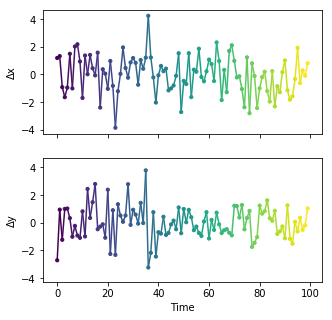

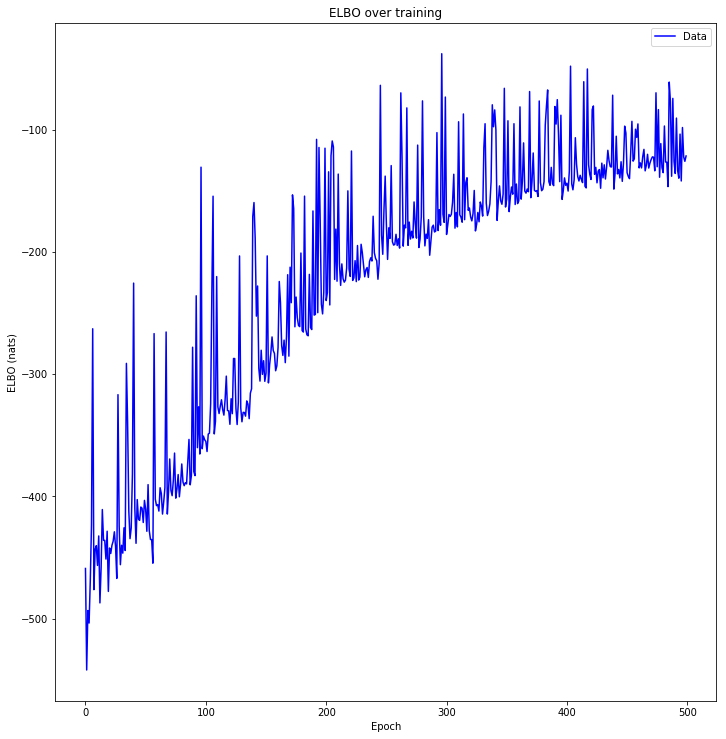

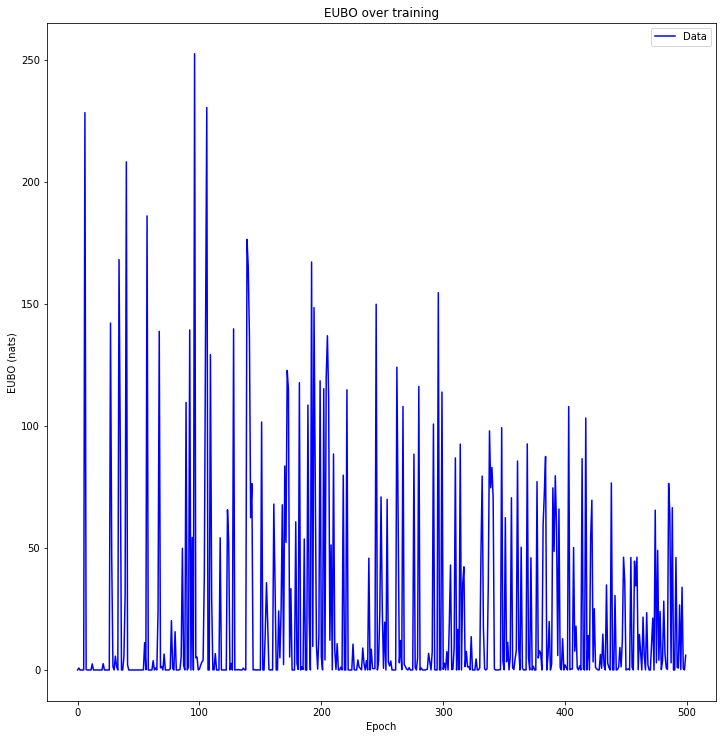

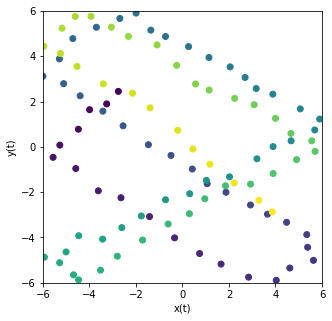

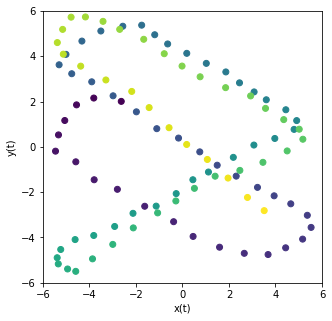

03/05/2019 15:25:45 MSE at time 0: tensor(0.2102)
03/05/2019 15:25:45 MSE at time 1: tensor(0.3749)
03/05/2019 15:25:45 MSE at time 2: tensor(0.3609)
03/05/2019 15:25:45 MSE at time 3: tensor(0.4908)
03/05/2019 15:25:45 MSE at time 4: tensor(0.2074)
03/05/2019 15:25:45 MSE at time 5: tensor(0.0847)
03/05/2019 15:25:45 MSE at time 6: tensor(0.0874)
03/05/2019 15:25:45 MSE at time 7: tensor(0.2704)
03/05/2019 15:25:45 MSE at time 8: tensor(0.1619)
03/05/2019 15:25:45 MSE at time 9: tensor(0.2512)
03/05/2019 15:25:45 MSE at time 10: tensor(0.5115)
03/05/2019 15:25:45 MSE at time 11: tensor(0.6474)
03/05/2019 15:25:45 MSE at time 12: tensor(0.5603)
03/05/2019 15:25:45 MSE at time 13: tensor(1.1389)
03/05/2019 15:25:45 MSE at time 14: tensor(1.4187)
03/05/2019 15:25:45 MSE at time 15: tensor(0.8284)
03/05/2019 15:25:45 MSE at time 16: tensor(1.0946)
03/05/2019 15:25:45 MSE at time 17: tensor(0.7917)
03/05/2019 15:25:45 MSE at time 18: tensor(0.7279)
03/05/2019 15:25:45 MSE at time 19: tenso

Epoch   110: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:26:06 EUBO=1.52571790e-03 at epoch 113
03/05/2019 15:26:06 EUBO=6.04747438e+00 at epoch 114
03/05/2019 15:26:07 EUBO=1.57870241e-02 at epoch 115
03/05/2019 15:26:07 EUBO=4.50611293e-01 at epoch 116
03/05/2019 15:26:07 EUBO=1.41887658e-03 at epoch 117
03/05/2019 15:26:07 EUBO=1.67158886e-03 at epoch 118
03/05/2019 15:26:07 EUBO=1.53843269e+01 at epoch 119
03/05/2019 15:26:07 EUBO=3.03319609e-08 at epoch 120
03/05/2019 15:26:08 EUBO=5.17826955e-08 at epoch 121
03/05/2019 15:26:08 EUBO=7.92442501e-01 at epoch 122
03/05/2019 15:26:08 EUBO=6.56015472e+01 at epoch 123
03/05/2019 15:26:08 EUBO=4.08556557e+01 at epoch 124
03/05/2019 15:26:08 EUBO=4.22695593e-04 at epoch 125
03/05/2019 15:26:09 EUBO=1.47403777e-02 at epoch 126
03/05/2019 15:26:09 EUBO=3.10779991e+01 at epoch 127
03/05/2019 15:26:09 EUBO=3.27252922e+01 at epoch 128
03/05/2019 15:26:09 EUBO=1.56647936e-01 at epoch 129
03/05/2019 15:26:09 EUBO=3.20869865e+01 at epoch 130
03/05/2019 15:26:10 EUBO=1.05832283e+02 at epo

Epoch   211: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:26:25 EUBO=9.50407162e-02 at epoch 214
03/05/2019 15:26:25 EUBO=3.28650856e+01 at epoch 215
03/05/2019 15:26:25 EUBO=7.09870338e+00 at epoch 216
03/05/2019 15:26:25 EUBO=2.43713045e+00 at epoch 217
03/05/2019 15:26:26 EUBO=4.04507279e-01 at epoch 218
03/05/2019 15:26:26 EUBO=3.55586107e-03 at epoch 219
03/05/2019 15:26:26 EUBO=2.24589958e+01 at epoch 220
03/05/2019 15:26:26 EUBO=4.74020511e-01 at epoch 221
03/05/2019 15:26:26 EUBO=3.18325758e+00 at epoch 222
03/05/2019 15:26:27 EUBO=3.75058539e-02 at epoch 223
03/05/2019 15:26:27 EUBO=3.72005916e+00 at epoch 224
03/05/2019 15:26:27 EUBO=2.14695372e-03 at epoch 225
03/05/2019 15:26:27 EUBO=2.72390902e-01 at epoch 226
03/05/2019 15:26:27 EUBO=4.92671728e+00 at epoch 227
03/05/2019 15:26:27 EUBO=4.65394402e+01 at epoch 228
03/05/2019 15:26:28 EUBO=1.30135362e-04 at epoch 229
03/05/2019 15:26:28 EUBO=4.51237335e+01 at epoch 230
03/05/2019 15:26:28 EUBO=5.37500954e+00 at epoch 231
03/05/2019 15:26:28 EUBO=2.05604272e-04 at epo

Epoch   312: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 15:26:44 EUBO=4.14759037e-04 at epoch 315
03/05/2019 15:26:44 EUBO=6.47744834e-02 at epoch 316
03/05/2019 15:26:44 EUBO=7.97704840e+00 at epoch 317
03/05/2019 15:26:44 EUBO=1.36215639e+01 at epoch 318
03/05/2019 15:26:44 EUBO=1.05610504e+01 at epoch 319
03/05/2019 15:26:44 EUBO=1.26513615e+01 at epoch 320
03/05/2019 15:26:45 EUBO=9.00118408e+01 at epoch 321
03/05/2019 15:26:45 EUBO=9.95126152e+00 at epoch 322
03/05/2019 15:26:45 EUBO=4.14225435e+00 at epoch 323
03/05/2019 15:26:45 EUBO=4.26437310e-07 at epoch 324
03/05/2019 15:26:45 EUBO=9.58765316e+00 at epoch 325
03/05/2019 15:26:45 EUBO=6.80297546e+01 at epoch 326
03/05/2019 15:26:46 EUBO=7.54976578e+01 at epoch 327
03/05/2019 15:26:46 EUBO=1.29532185e+01 at epoch 328
03/05/2019 15:26:46 EUBO=2.14269142e+01 at epoch 329
03/05/2019 15:26:46 EUBO=1.07807760e+01 at epoch 330
03/05/2019 15:26:46 EUBO=8.41937733e+00 at epoch 331
03/05/2019 15:26:46 EUBO=1.59354386e-04 at epoch 332
03/05/2019 15:26:47 EUBO=9.54997122e-01 at epo

Epoch   413: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 15:27:01 EUBO=7.81079009e-03 at epoch 416
03/05/2019 15:27:01 EUBO=1.72947664e-04 at epoch 417
03/05/2019 15:27:01 EUBO=5.51451588e+00 at epoch 418
03/05/2019 15:27:01 EUBO=5.14844742e+01 at epoch 419
03/05/2019 15:27:01 EUBO=2.88267829e-03 at epoch 420
03/05/2019 15:27:02 EUBO=1.07140493e+00 at epoch 421
03/05/2019 15:27:02 EUBO=3.12061825e+01 at epoch 422
03/05/2019 15:27:02 EUBO=1.40780725e+01 at epoch 423
03/05/2019 15:27:02 EUBO=7.72219002e-01 at epoch 424
03/05/2019 15:27:02 EUBO=3.94023118e-05 at epoch 425
03/05/2019 15:27:03 EUBO=2.42874324e-01 at epoch 426
03/05/2019 15:27:03 EUBO=2.78245697e+01 at epoch 427
03/05/2019 15:27:03 EUBO=1.82955228e-02 at epoch 428
03/05/2019 15:27:03 EUBO=4.23025179e+00 at epoch 429
03/05/2019 15:27:03 EUBO=5.47855198e-02 at epoch 430
03/05/2019 15:27:04 EUBO=1.17817137e-03 at epoch 431
03/05/2019 15:27:04 EUBO=9.58702743e-01 at epoch 432
03/05/2019 15:27:04 EUBO=1.04943399e+01 at epoch 433
03/05/2019 15:27:04 EUBO=3.78335915e+01 at epo

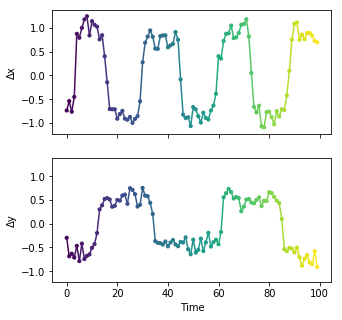

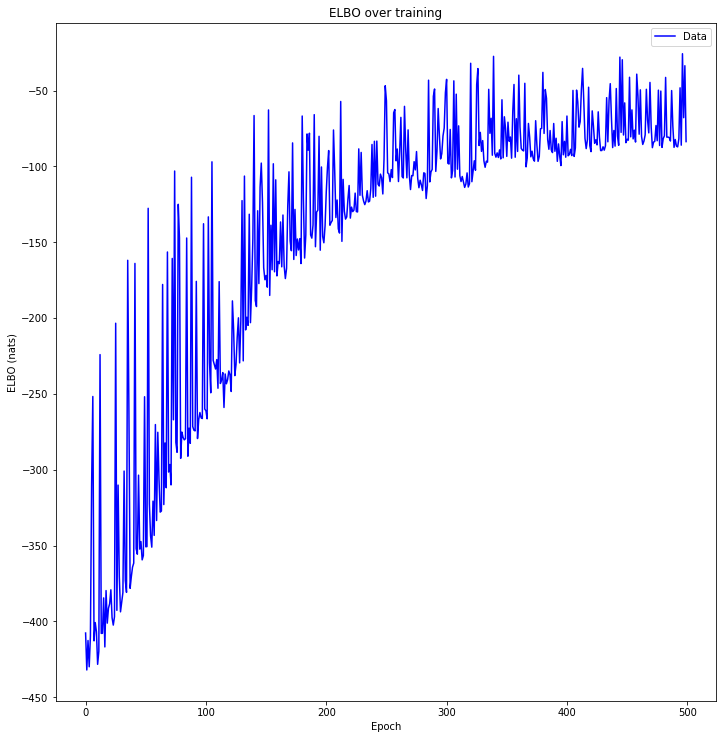

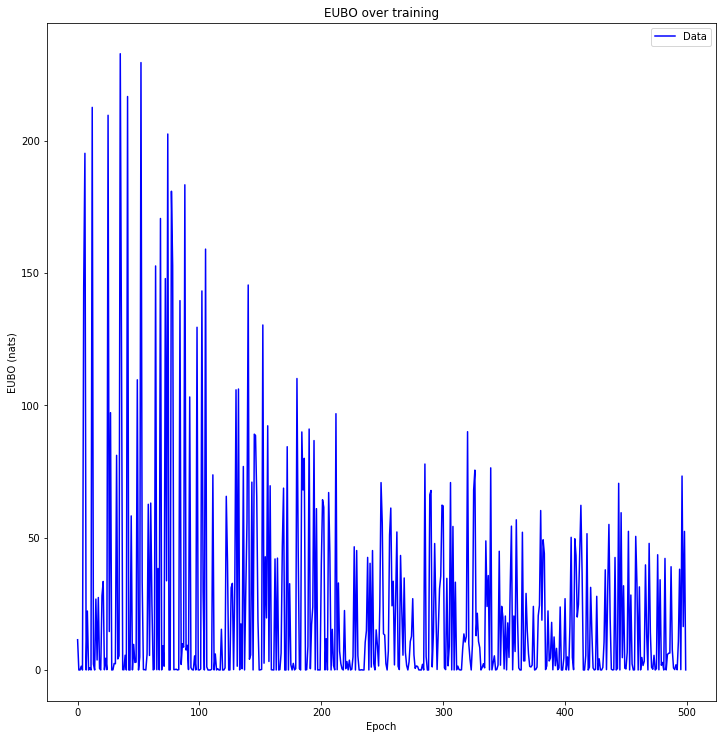

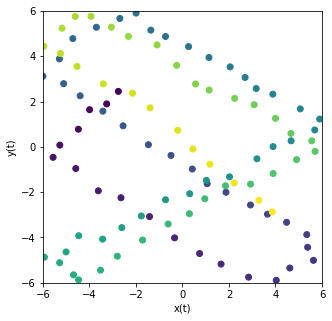

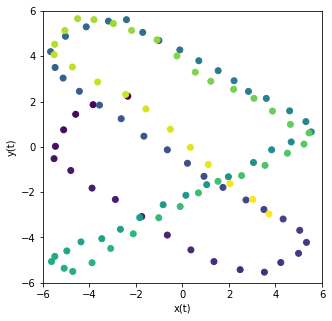

03/05/2019 15:27:17 MSE at time 0: tensor(0.2104)
03/05/2019 15:27:17 MSE at time 1: tensor(0.3436)
03/05/2019 15:27:17 MSE at time 2: tensor(0.4005)
03/05/2019 15:27:17 MSE at time 3: tensor(0.4019)
03/05/2019 15:27:17 MSE at time 4: tensor(0.0385)
03/05/2019 15:27:17 MSE at time 5: tensor(0.0051)
03/05/2019 15:27:17 MSE at time 6: tensor(0.0538)
03/05/2019 15:27:17 MSE at time 7: tensor(0.0873)
03/05/2019 15:27:17 MSE at time 8: tensor(0.0640)
03/05/2019 15:27:17 MSE at time 9: tensor(0.1113)
03/05/2019 15:27:17 MSE at time 10: tensor(0.1129)
03/05/2019 15:27:17 MSE at time 11: tensor(0.1648)
03/05/2019 15:27:17 MSE at time 12: tensor(0.1057)
03/05/2019 15:27:17 MSE at time 13: tensor(0.2405)
03/05/2019 15:27:17 MSE at time 14: tensor(0.3905)
03/05/2019 15:27:17 MSE at time 15: tensor(0.2092)
03/05/2019 15:27:17 MSE at time 16: tensor(0.5060)
03/05/2019 15:27:17 MSE at time 17: tensor(0.0492)
03/05/2019 15:27:17 MSE at time 18: tensor(0.1284)
03/05/2019 15:27:17 MSE at time 19: tenso

Epoch   282: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:28:17 ELBO=-6.39617432e+02 at epoch 285
03/05/2019 15:28:18 ELBO=-6.57160278e+02 at epoch 286
03/05/2019 15:28:18 ELBO=-6.43300415e+02 at epoch 287
03/05/2019 15:28:18 ELBO=-6.42878479e+02 at epoch 288
03/05/2019 15:28:18 ELBO=-6.87193359e+02 at epoch 289
03/05/2019 15:28:18 ELBO=-6.48269958e+02 at epoch 290
03/05/2019 15:28:19 ELBO=-6.34933472e+02 at epoch 291
03/05/2019 15:28:19 ELBO=-6.70274109e+02 at epoch 292
03/05/2019 15:28:19 ELBO=-6.29246460e+02 at epoch 293
03/05/2019 15:28:19 ELBO=-6.28200195e+02 at epoch 294
03/05/2019 15:28:19 ELBO=-6.58621887e+02 at epoch 295
03/05/2019 15:28:20 ELBO=-6.01415771e+02 at epoch 296
03/05/2019 15:28:20 ELBO=-6.43538208e+02 at epoch 297
03/05/2019 15:28:20 ELBO=-6.27262512e+02 at epoch 298
03/05/2019 15:28:20 ELBO=-6.37241516e+02 at epoch 299
03/05/2019 15:28:20 ELBO=-6.28881531e+02 at epoch 300
03/05/2019 15:28:21 ELBO=-6.25624573e+02 at epoch 301
03/05/2019 15:28:21 ELBO=-7.08075867e+02 at epoch 302
03/05/2019 15:28:21 ELBO=-6.

Epoch   383: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:28:38 ELBO=-6.28037354e+02 at epoch 386
03/05/2019 15:28:38 ELBO=-6.31111877e+02 at epoch 387
03/05/2019 15:28:38 ELBO=-6.47993774e+02 at epoch 388
03/05/2019 15:28:39 ELBO=-6.48966064e+02 at epoch 389
03/05/2019 15:28:39 ELBO=-6.18959656e+02 at epoch 390
03/05/2019 15:28:39 ELBO=-6.14289734e+02 at epoch 391
03/05/2019 15:28:39 ELBO=-6.82049866e+02 at epoch 392
03/05/2019 15:28:40 ELBO=-6.26142761e+02 at epoch 393
03/05/2019 15:28:40 ELBO=-6.10490723e+02 at epoch 394
03/05/2019 15:28:40 ELBO=-6.24712402e+02 at epoch 395
03/05/2019 15:28:40 ELBO=-6.32660034e+02 at epoch 396
03/05/2019 15:28:40 ELBO=-6.53361633e+02 at epoch 397
03/05/2019 15:28:41 ELBO=-6.40195068e+02 at epoch 398
03/05/2019 15:28:41 ELBO=-6.31686157e+02 at epoch 399
03/05/2019 15:28:41 ELBO=-6.32302734e+02 at epoch 400
03/05/2019 15:28:41 ELBO=-6.42112183e+02 at epoch 401
03/05/2019 15:28:42 ELBO=-6.30098755e+02 at epoch 402
03/05/2019 15:28:42 ELBO=-6.24828796e+02 at epoch 403
03/05/2019 15:28:42 ELBO=-6.

Epoch   484: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 15:29:00 ELBO=-6.12874146e+02 at epoch 487
03/05/2019 15:29:01 ELBO=-6.31542969e+02 at epoch 488
03/05/2019 15:29:01 ELBO=-6.42926636e+02 at epoch 489
03/05/2019 15:29:01 ELBO=-6.45392944e+02 at epoch 490
03/05/2019 15:29:01 ELBO=-6.45965942e+02 at epoch 491
03/05/2019 15:29:02 ELBO=-6.43925537e+02 at epoch 492
03/05/2019 15:29:02 ELBO=-6.34162109e+02 at epoch 493
03/05/2019 15:29:02 ELBO=-6.53378235e+02 at epoch 494
03/05/2019 15:29:02 ELBO=-6.36054382e+02 at epoch 495
03/05/2019 15:29:02 ELBO=-6.18603577e+02 at epoch 496
03/05/2019 15:29:03 ELBO=-6.44919678e+02 at epoch 497
03/05/2019 15:29:03 ELBO=-6.57216431e+02 at epoch 498
03/05/2019 15:29:03 ELBO=-6.41779541e+02 at epoch 499
03/05/2019 15:29:03 ELBO=-6.27558533e+02 at epoch 500


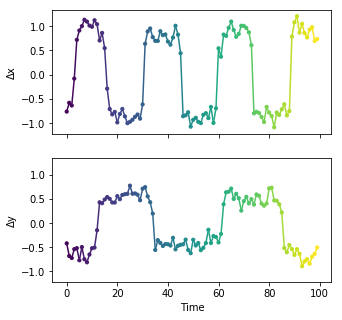

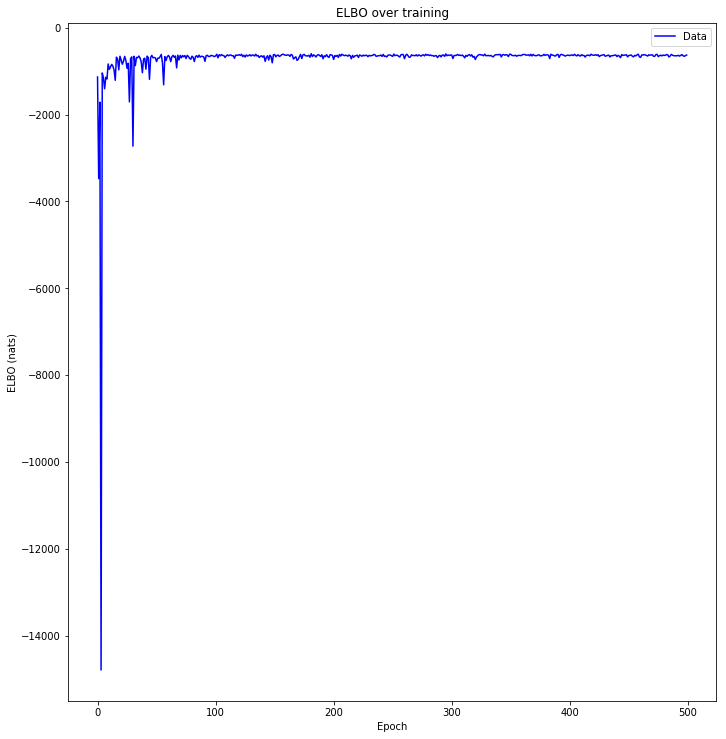

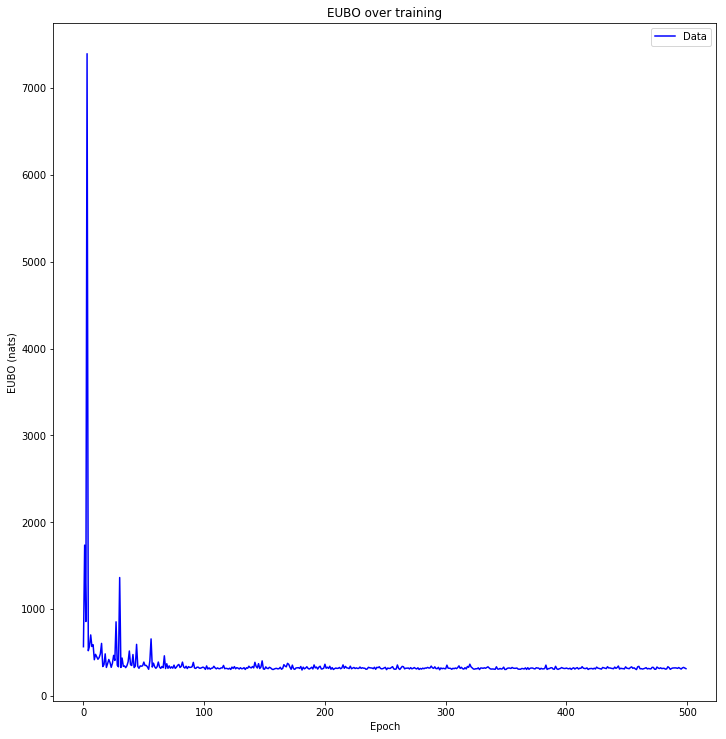

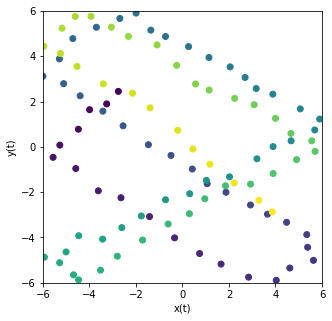

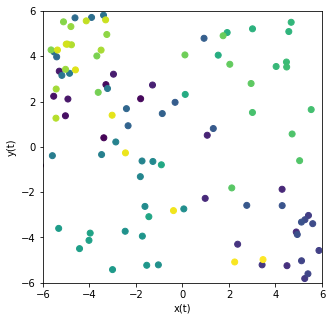

03/05/2019 15:29:04 MSE at time 0: tensor(21.9848)
03/05/2019 15:29:04 MSE at time 1: tensor(2.2520)
03/05/2019 15:29:04 MSE at time 2: tensor(5.0509)
03/05/2019 15:29:04 MSE at time 3: tensor(5.2808)
03/05/2019 15:29:04 MSE at time 4: tensor(1.7379)
03/05/2019 15:29:04 MSE at time 5: tensor(7.2769)
03/05/2019 15:29:04 MSE at time 6: tensor(9.5237)
03/05/2019 15:29:04 MSE at time 7: tensor(30.7171)
03/05/2019 15:29:04 MSE at time 8: tensor(29.8505)
03/05/2019 15:29:04 MSE at time 9: tensor(33.7627)
03/05/2019 15:29:04 MSE at time 10: tensor(22.5006)
03/05/2019 15:29:04 MSE at time 11: tensor(20.6394)
03/05/2019 15:29:04 MSE at time 12: tensor(8.8905)
03/05/2019 15:29:04 MSE at time 13: tensor(8.1759)
03/05/2019 15:29:04 MSE at time 14: tensor(0.6289)
03/05/2019 15:29:04 MSE at time 15: tensor(6.1393)
03/05/2019 15:29:04 MSE at time 16: tensor(4.9166)
03/05/2019 15:29:04 MSE at time 17: tensor(1.9217)
03/05/2019 15:29:04 MSE at time 18: tensor(0.7217)
03/05/2019 15:29:04 MSE at time 19:

Epoch   240: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:29:55 ELBO=-2.49244553e+02 at epoch 243
03/05/2019 15:29:55 ELBO=-2.79809875e+02 at epoch 244
03/05/2019 15:29:56 ELBO=-3.01100372e+02 at epoch 245
03/05/2019 15:29:56 ELBO=-2.70140106e+02 at epoch 246
03/05/2019 15:29:56 ELBO=-2.18225861e+02 at epoch 247
03/05/2019 15:29:56 ELBO=-2.67773712e+02 at epoch 248
03/05/2019 15:29:57 ELBO=-2.77736328e+02 at epoch 249
03/05/2019 15:29:57 ELBO=-2.64711609e+02 at epoch 250
03/05/2019 15:29:57 ELBO=-2.78687897e+02 at epoch 251
03/05/2019 15:29:57 ELBO=-2.68203918e+02 at epoch 252
03/05/2019 15:29:57 ELBO=-2.32389069e+02 at epoch 253
03/05/2019 15:29:58 ELBO=-2.33931915e+02 at epoch 254
03/05/2019 15:29:58 ELBO=-2.62137177e+02 at epoch 255
03/05/2019 15:29:58 ELBO=-2.34691498e+02 at epoch 256
03/05/2019 15:29:58 ELBO=-2.44765533e+02 at epoch 257
03/05/2019 15:29:58 ELBO=-2.43504959e+02 at epoch 258
03/05/2019 15:29:59 ELBO=-2.38182220e+02 at epoch 259
03/05/2019 15:29:59 ELBO=-2.32296539e+02 at epoch 260
03/05/2019 15:29:59 ELBO=-2.

Epoch   414: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:30:34 ELBO=-2.46251053e+02 at epoch 417
03/05/2019 15:30:34 ELBO=-2.16519684e+02 at epoch 418
03/05/2019 15:30:34 ELBO=-2.62256165e+02 at epoch 419
03/05/2019 15:30:34 ELBO=-2.37584991e+02 at epoch 420
03/05/2019 15:30:34 ELBO=-2.26735260e+02 at epoch 421
03/05/2019 15:30:35 ELBO=-2.74531921e+02 at epoch 422
03/05/2019 15:30:35 ELBO=-2.34183624e+02 at epoch 423
03/05/2019 15:30:35 ELBO=-2.17706390e+02 at epoch 424
03/05/2019 15:30:35 ELBO=-2.74930481e+02 at epoch 425
03/05/2019 15:30:36 ELBO=-2.32600006e+02 at epoch 426
03/05/2019 15:30:36 ELBO=-2.77449768e+02 at epoch 427
03/05/2019 15:30:36 ELBO=-2.39074982e+02 at epoch 428
03/05/2019 15:30:36 ELBO=-2.48820526e+02 at epoch 429
03/05/2019 15:30:36 ELBO=-2.43563873e+02 at epoch 430
03/05/2019 15:30:37 ELBO=-2.40537933e+02 at epoch 431
03/05/2019 15:30:37 ELBO=-2.08489532e+02 at epoch 432
03/05/2019 15:30:37 ELBO=-2.51637695e+02 at epoch 433
03/05/2019 15:30:37 ELBO=-2.33485382e+02 at epoch 434
03/05/2019 15:30:38 ELBO=-2.

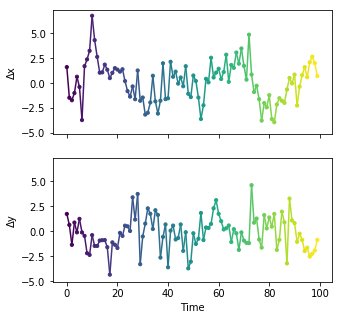

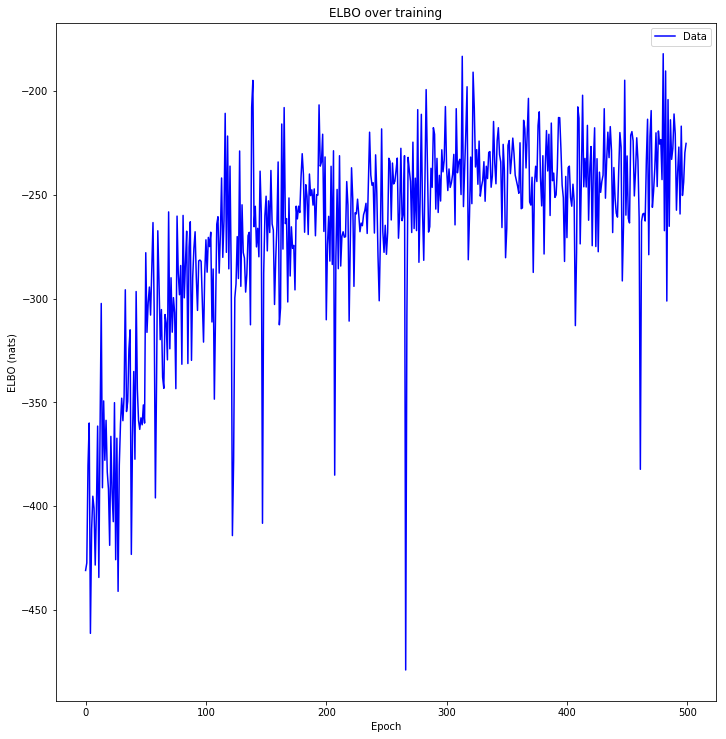

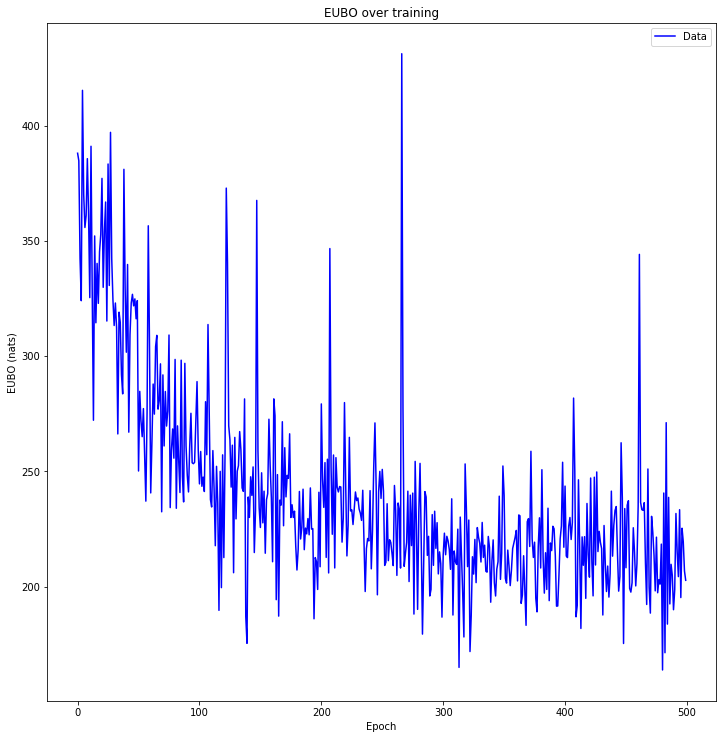

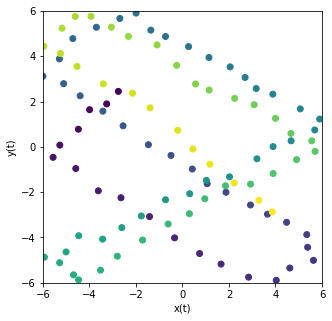

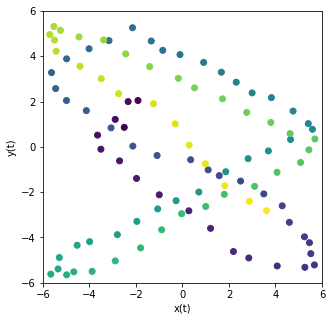

03/05/2019 15:30:53 MSE at time 0: tensor(2.5851)
03/05/2019 15:30:53 MSE at time 1: tensor(1.8364)
03/05/2019 15:30:53 MSE at time 2: tensor(2.8681)
03/05/2019 15:30:53 MSE at time 3: tensor(2.6980)
03/05/2019 15:30:53 MSE at time 4: tensor(2.8271)
03/05/2019 15:30:53 MSE at time 5: tensor(4.3559)
03/05/2019 15:30:53 MSE at time 6: tensor(3.6611)
03/05/2019 15:30:53 MSE at time 7: tensor(2.9999)
03/05/2019 15:30:53 MSE at time 8: tensor(2.7260)
03/05/2019 15:30:53 MSE at time 9: tensor(2.9222)
03/05/2019 15:30:53 MSE at time 10: tensor(2.5717)
03/05/2019 15:30:53 MSE at time 11: tensor(2.1269)
03/05/2019 15:30:53 MSE at time 12: tensor(1.4938)
03/05/2019 15:30:53 MSE at time 13: tensor(1.7558)
03/05/2019 15:30:53 MSE at time 14: tensor(1.8420)
03/05/2019 15:30:53 MSE at time 15: tensor(1.1364)
03/05/2019 15:30:53 MSE at time 16: tensor(0.1001)
03/05/2019 15:30:53 MSE at time 17: tensor(0.0466)
03/05/2019 15:30:53 MSE at time 18: tensor(0.0195)
03/05/2019 15:30:53 MSE at time 19: tenso

Epoch   199: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:31:46 ELBO=-3.51109528e+02 at epoch 201
03/05/2019 15:31:46 ELBO=-3.14385345e+02 at epoch 202
03/05/2019 15:31:46 ELBO=-4.27359772e+02 at epoch 203
03/05/2019 15:31:47 ELBO=-4.94368866e+02 at epoch 204
03/05/2019 15:31:47 ELBO=-3.66447418e+02 at epoch 205
03/05/2019 15:31:47 ELBO=-2.58736176e+02 at epoch 206
03/05/2019 15:31:47 ELBO=-2.92700714e+02 at epoch 207
03/05/2019 15:31:48 ELBO=-3.11789032e+02 at epoch 208
03/05/2019 15:31:48 ELBO=-3.17669891e+02 at epoch 209
03/05/2019 15:31:48 ELBO=-3.91884216e+02 at epoch 210
03/05/2019 15:31:49 ELBO=-3.06785187e+02 at epoch 211
03/05/2019 15:31:49 ELBO=-3.94915314e+02 at epoch 212
03/05/2019 15:31:49 ELBO=-3.33692200e+02 at epoch 213
03/05/2019 15:31:49 ELBO=-4.68433228e+02 at epoch 214
03/05/2019 15:31:50 ELBO=-3.32512848e+02 at epoch 215
03/05/2019 15:31:50 ELBO=-3.46493591e+02 at epoch 216
03/05/2019 15:31:50 ELBO=-3.32781982e+02 at epoch 217
03/05/2019 15:31:51 ELBO=-3.75694885e+02 at epoch 218
03/05/2019 15:31:51 ELBO=-3.

Epoch   329: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:32:21 ELBO=-4.18817688e+02 at epoch 331
03/05/2019 15:32:21 ELBO=-3.65304535e+02 at epoch 332
03/05/2019 15:32:22 ELBO=-3.93772156e+02 at epoch 333
03/05/2019 15:32:22 ELBO=-3.79901520e+02 at epoch 334
03/05/2019 15:32:22 ELBO=-2.96958496e+02 at epoch 335
03/05/2019 15:32:22 ELBO=-3.51735596e+02 at epoch 336
03/05/2019 15:32:23 ELBO=-4.46875458e+02 at epoch 337
03/05/2019 15:32:23 ELBO=-2.61207642e+02 at epoch 338
03/05/2019 15:32:23 ELBO=-4.23294098e+02 at epoch 339
03/05/2019 15:32:23 ELBO=-2.84389099e+02 at epoch 340
03/05/2019 15:32:24 ELBO=-4.63359009e+02 at epoch 341
03/05/2019 15:32:24 ELBO=-3.27657623e+02 at epoch 342
03/05/2019 15:32:24 ELBO=-3.69407074e+02 at epoch 343
03/05/2019 15:32:25 ELBO=-3.39128235e+02 at epoch 344
03/05/2019 15:32:25 ELBO=-4.09942688e+02 at epoch 345
03/05/2019 15:32:25 ELBO=-3.07179077e+02 at epoch 346
03/05/2019 15:32:25 ELBO=-2.96736145e+02 at epoch 347
03/05/2019 15:32:26 ELBO=-3.58172974e+02 at epoch 348
03/05/2019 15:32:26 ELBO=-3.

Epoch   430: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 15:32:48 ELBO=-3.99742920e+02 at epoch 432
03/05/2019 15:32:48 ELBO=-2.65924500e+02 at epoch 433
03/05/2019 15:32:48 ELBO=-4.51753876e+02 at epoch 434
03/05/2019 15:32:49 ELBO=-3.78371826e+02 at epoch 435
03/05/2019 15:32:49 ELBO=-3.59099731e+02 at epoch 436
03/05/2019 15:32:49 ELBO=-2.15804001e+02 at epoch 437
03/05/2019 15:32:50 ELBO=-3.81010498e+02 at epoch 438
03/05/2019 15:32:50 ELBO=-2.81406219e+02 at epoch 439
03/05/2019 15:32:50 ELBO=-3.29148895e+02 at epoch 440
03/05/2019 15:32:50 ELBO=-3.43650940e+02 at epoch 441
03/05/2019 15:32:51 ELBO=-2.99890656e+02 at epoch 442
03/05/2019 15:32:51 ELBO=-3.25837921e+02 at epoch 443
03/05/2019 15:32:51 ELBO=-3.65416870e+02 at epoch 444
03/05/2019 15:32:51 ELBO=-3.21338501e+02 at epoch 445
03/05/2019 15:32:52 ELBO=-3.63902313e+02 at epoch 446
03/05/2019 15:32:52 ELBO=-3.58551453e+02 at epoch 447
03/05/2019 15:32:52 ELBO=-2.79436859e+02 at epoch 448
03/05/2019 15:32:52 ELBO=-3.41210968e+02 at epoch 449
03/05/2019 15:32:53 ELBO=-1.

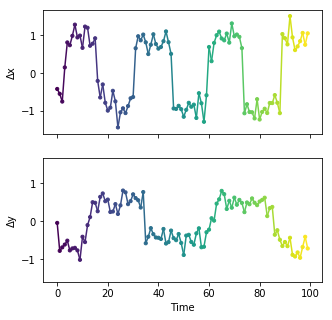

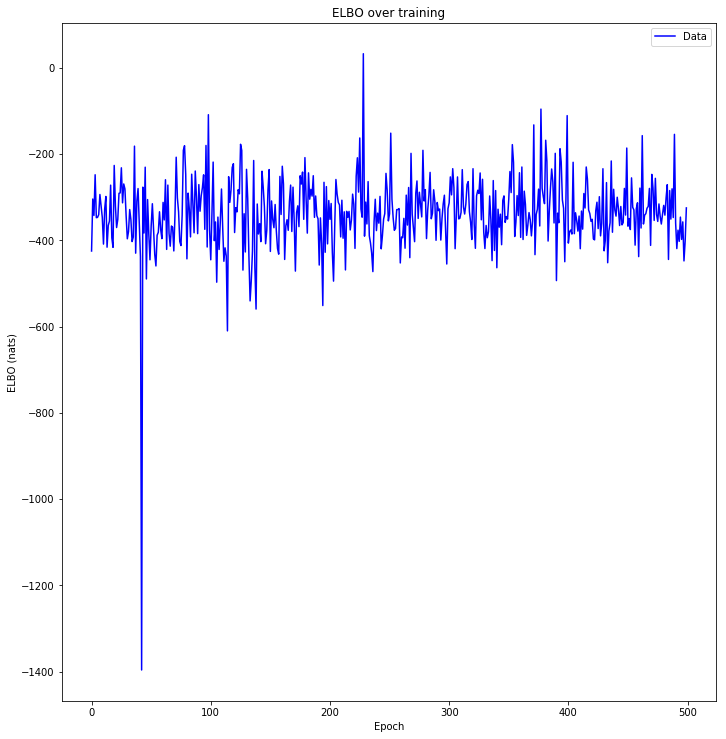

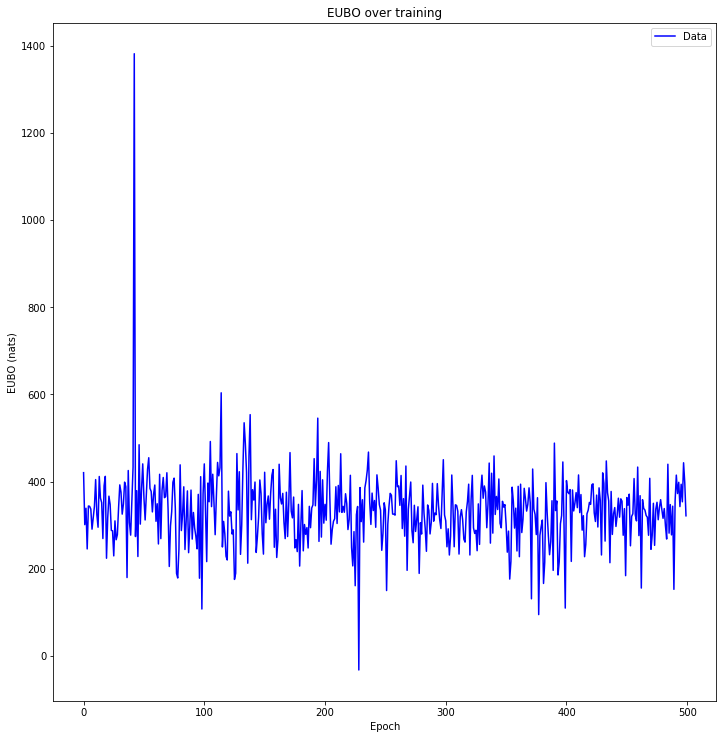

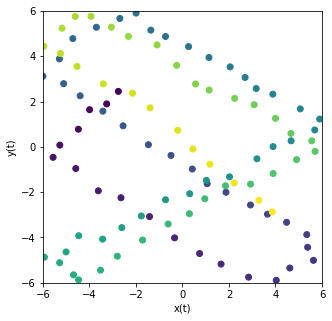

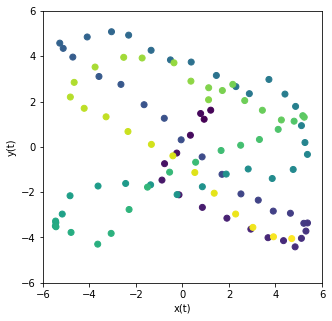

03/05/2019 15:33:06 MSE at time 0: tensor(15.1271)
03/05/2019 15:33:06 MSE at time 1: tensor(20.0983)
03/05/2019 15:33:06 MSE at time 2: tensor(22.8351)
03/05/2019 15:33:06 MSE at time 3: tensor(23.2912)
03/05/2019 15:33:06 MSE at time 4: tensor(25.4086)
03/05/2019 15:33:06 MSE at time 5: tensor(23.0614)
03/05/2019 15:33:06 MSE at time 6: tensor(14.0074)
03/05/2019 15:33:06 MSE at time 7: tensor(12.0823)
03/05/2019 15:33:06 MSE at time 8: tensor(12.4363)
03/05/2019 15:33:06 MSE at time 9: tensor(11.0799)
03/05/2019 15:33:06 MSE at time 10: tensor(10.9110)
03/05/2019 15:33:06 MSE at time 11: tensor(9.1493)
03/05/2019 15:33:06 MSE at time 12: tensor(8.2834)
03/05/2019 15:33:06 MSE at time 13: tensor(5.7931)
03/05/2019 15:33:06 MSE at time 14: tensor(4.6046)
03/05/2019 15:33:06 MSE at time 15: tensor(3.1429)
03/05/2019 15:33:06 MSE at time 16: tensor(2.7894)
03/05/2019 15:33:06 MSE at time 17: tensor(1.1467)
03/05/2019 15:33:06 MSE at time 18: tensor(1.3853)
03/05/2019 15:33:06 MSE at tim

Epoch   207: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:33:53 EUBO=3.42200958e+02 at epoch 210
03/05/2019 15:33:54 EUBO=5.78358704e+02 at epoch 211
03/05/2019 15:33:54 EUBO=3.57378540e+02 at epoch 212
03/05/2019 15:33:54 EUBO=6.13999878e+02 at epoch 213
03/05/2019 15:33:54 EUBO=3.32186584e+02 at epoch 214
03/05/2019 15:33:54 EUBO=5.03465576e+02 at epoch 215
03/05/2019 15:33:55 EUBO=3.29730988e+02 at epoch 216
03/05/2019 15:33:55 EUBO=3.51833679e+02 at epoch 217
03/05/2019 15:33:55 EUBO=3.94609406e+02 at epoch 218
03/05/2019 15:33:55 EUBO=3.88073151e+02 at epoch 219
03/05/2019 15:33:56 EUBO=4.74389923e+02 at epoch 220
03/05/2019 15:33:56 EUBO=4.30106812e+02 at epoch 221
03/05/2019 15:33:56 EUBO=3.20663727e+02 at epoch 222
03/05/2019 15:33:56 EUBO=3.49570923e+02 at epoch 223
03/05/2019 15:33:56 EUBO=3.36677795e+02 at epoch 224
03/05/2019 15:33:57 EUBO=3.65968384e+02 at epoch 225
03/05/2019 15:33:57 EUBO=6.73039978e+02 at epoch 226
03/05/2019 15:33:57 EUBO=3.73480621e+02 at epoch 227
03/05/2019 15:33:57 EUBO=5.29254211e+02 at epo

Epoch   335: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:34:21 EUBO=4.09576996e+02 at epoch 338
03/05/2019 15:34:22 EUBO=4.86996582e+02 at epoch 339
03/05/2019 15:34:22 EUBO=4.20572388e+02 at epoch 340
03/05/2019 15:34:22 EUBO=3.16835999e+02 at epoch 341
03/05/2019 15:34:22 EUBO=9.15027832e+02 at epoch 342
03/05/2019 15:34:22 EUBO=3.72218018e+02 at epoch 343
03/05/2019 15:34:23 EUBO=4.16077881e+02 at epoch 344
03/05/2019 15:34:23 EUBO=3.23203308e+02 at epoch 345
03/05/2019 15:34:23 EUBO=3.83293488e+02 at epoch 346
03/05/2019 15:34:23 EUBO=4.49106079e+02 at epoch 347
03/05/2019 15:34:23 EUBO=4.18032318e+02 at epoch 348
03/05/2019 15:34:24 EUBO=3.41358246e+02 at epoch 349
03/05/2019 15:34:24 EUBO=3.91548798e+02 at epoch 350
03/05/2019 15:34:24 EUBO=3.80910309e+02 at epoch 351
03/05/2019 15:34:24 EUBO=3.46035614e+02 at epoch 352
03/05/2019 15:34:24 EUBO=5.03504883e+02 at epoch 353
03/05/2019 15:34:25 EUBO=4.03190735e+02 at epoch 354
03/05/2019 15:34:25 EUBO=3.79089569e+02 at epoch 355
03/05/2019 15:34:25 EUBO=5.50142456e+02 at epo

Epoch   497: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 15:34:56 EUBO=4.63841034e+02 at epoch 500


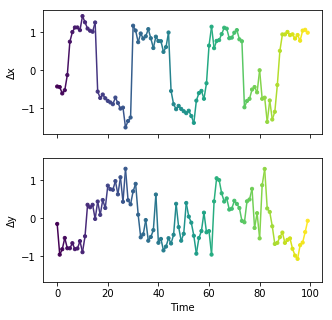

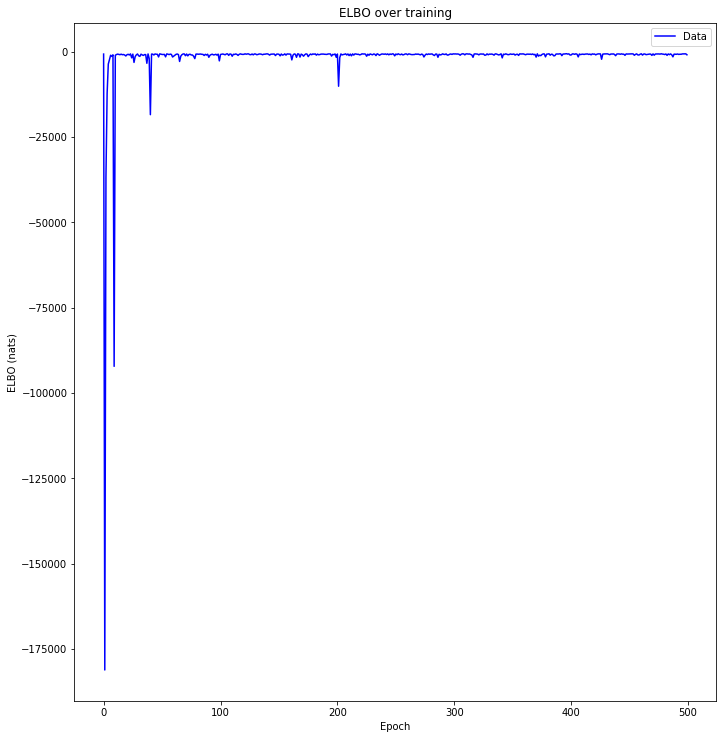

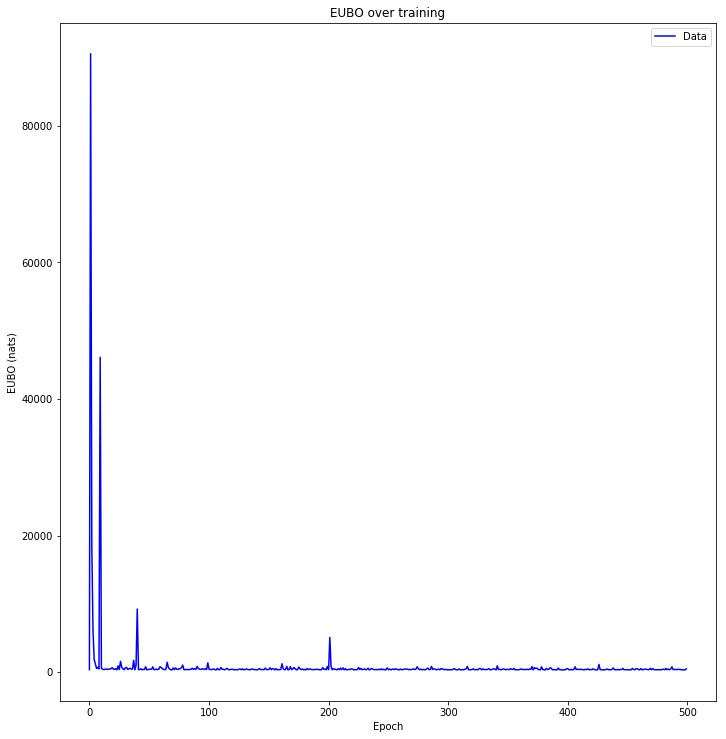

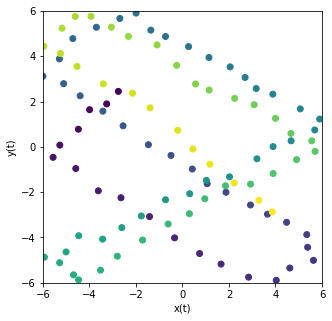

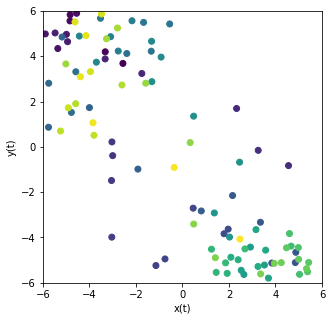

03/05/2019 15:34:57 MSE at time 0: tensor(1.5637)
03/05/2019 15:34:57 MSE at time 1: tensor(5.2946)
03/05/2019 15:34:57 MSE at time 2: tensor(18.2753)
03/05/2019 15:34:57 MSE at time 3: tensor(22.9977)
03/05/2019 15:34:57 MSE at time 4: tensor(34.4065)
03/05/2019 15:34:57 MSE at time 5: tensor(23.1076)
03/05/2019 15:34:57 MSE at time 6: tensor(37.0132)
03/05/2019 15:34:57 MSE at time 7: tensor(49.6065)
03/05/2019 15:34:57 MSE at time 8: tensor(52.7271)
03/05/2019 15:34:57 MSE at time 9: tensor(82.2424)
03/05/2019 15:34:57 MSE at time 10: tensor(71.3316)
03/05/2019 15:34:57 MSE at time 11: tensor(69.3471)
03/05/2019 15:34:57 MSE at time 12: tensor(47.6436)
03/05/2019 15:34:57 MSE at time 13: tensor(27.1960)
03/05/2019 15:34:57 MSE at time 14: tensor(33.5370)
03/05/2019 15:34:57 MSE at time 15: tensor(82.6462)
03/05/2019 15:34:57 MSE at time 16: tensor(102.4398)
03/05/2019 15:34:57 MSE at time 17: tensor(79.8709)
03/05/2019 15:34:57 MSE at time 18: tensor(70.3497)
03/05/2019 15:34:57 MSE

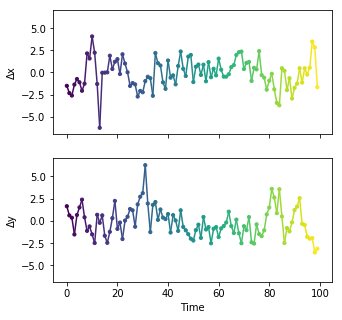

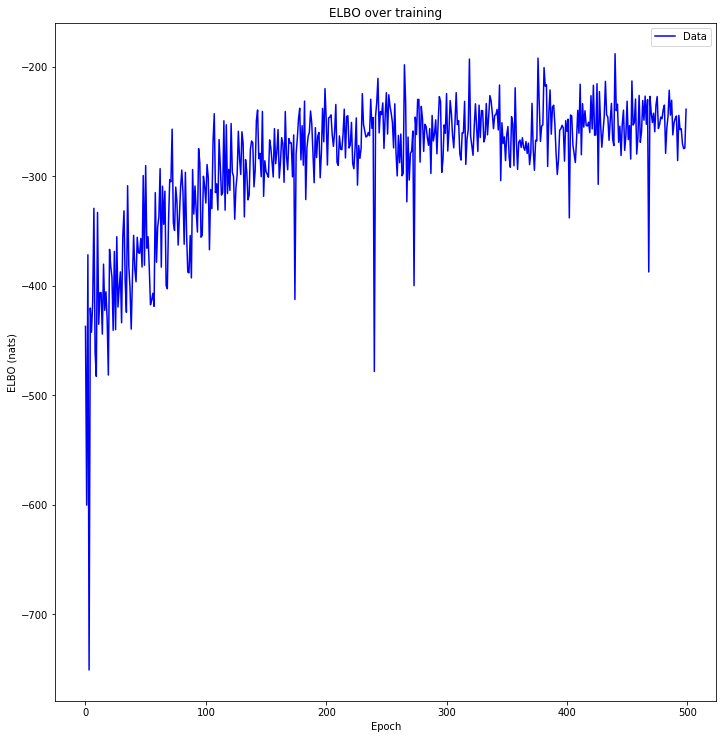

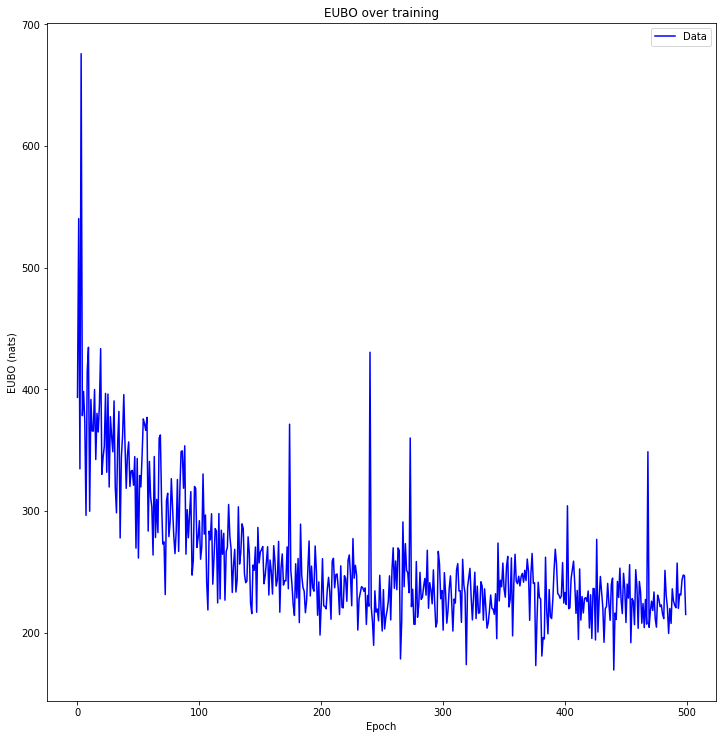

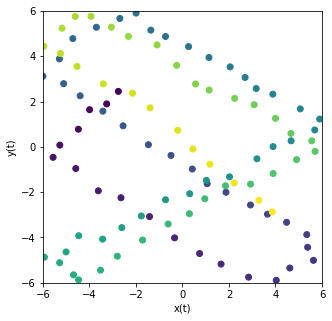

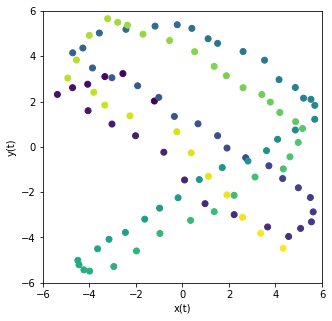

03/05/2019 15:36:50 MSE at time 0: tensor(2.5810)
03/05/2019 15:36:50 MSE at time 1: tensor(2.2793)
03/05/2019 15:36:50 MSE at time 2: tensor(2.5648)
03/05/2019 15:36:50 MSE at time 3: tensor(4.1050)
03/05/2019 15:36:50 MSE at time 4: tensor(6.7270)
03/05/2019 15:36:50 MSE at time 5: tensor(7.7356)
03/05/2019 15:36:50 MSE at time 6: tensor(6.7864)
03/05/2019 15:36:50 MSE at time 7: tensor(9.0330)
03/05/2019 15:36:50 MSE at time 8: tensor(7.8895)
03/05/2019 15:36:50 MSE at time 9: tensor(8.4587)
03/05/2019 15:36:50 MSE at time 10: tensor(6.7211)
03/05/2019 15:36:50 MSE at time 11: tensor(4.9025)
03/05/2019 15:36:50 MSE at time 12: tensor(5.0837)
03/05/2019 15:36:50 MSE at time 13: tensor(5.5754)
03/05/2019 15:36:50 MSE at time 14: tensor(4.0293)
03/05/2019 15:36:50 MSE at time 15: tensor(3.2741)
03/05/2019 15:36:50 MSE at time 16: tensor(2.8959)
03/05/2019 15:36:50 MSE at time 17: tensor(2.4960)
03/05/2019 15:36:50 MSE at time 18: tensor(2.7043)
03/05/2019 15:36:50 MSE at time 19: tenso

Epoch   367: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 15:38:37 EUBO=3.01262115e+02 at epoch 369
03/05/2019 15:38:37 EUBO=3.57817657e+02 at epoch 370
03/05/2019 15:38:38 EUBO=1.74486771e+02 at epoch 371
03/05/2019 15:38:38 EUBO=2.86664825e+02 at epoch 372
03/05/2019 15:38:38 EUBO=3.79432434e+02 at epoch 373
03/05/2019 15:38:38 EUBO=2.58753479e+02 at epoch 374
03/05/2019 15:38:39 EUBO=4.02649628e+02 at epoch 375
03/05/2019 15:38:39 EUBO=2.86425659e+02 at epoch 376
03/05/2019 15:38:39 EUBO=2.85604828e+02 at epoch 377
03/05/2019 15:38:40 EUBO=7.31532043e+02 at epoch 378
03/05/2019 15:38:40 EUBO=3.85189484e+02 at epoch 379
03/05/2019 15:38:40 EUBO=3.10069061e+02 at epoch 380
03/05/2019 15:38:40 EUBO=2.83099243e+02 at epoch 381
03/05/2019 15:38:41 EUBO=2.54012573e+02 at epoch 382
03/05/2019 15:38:41 EUBO=1.66058167e+02 at epoch 383
03/05/2019 15:38:41 EUBO=2.68438263e+02 at epoch 384
03/05/2019 15:38:42 EUBO=3.18777374e+02 at epoch 385
03/05/2019 15:38:42 EUBO=4.13467438e+02 at epoch 386
03/05/2019 15:38:42 EUBO=4.00970093e+02 at epo

Epoch   468: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 15:39:07 EUBO=3.15991180e+02 at epoch 470
03/05/2019 15:39:07 EUBO=2.41123993e+02 at epoch 471
03/05/2019 15:39:08 EUBO=1.74975754e+02 at epoch 472
03/05/2019 15:39:08 EUBO=2.65674835e+02 at epoch 473
03/05/2019 15:39:08 EUBO=3.01232330e+02 at epoch 474
03/05/2019 15:39:08 EUBO=3.83946472e+02 at epoch 475
03/05/2019 15:39:09 EUBO=2.50007172e+02 at epoch 476
03/05/2019 15:39:09 EUBO=3.39992920e+02 at epoch 477
03/05/2019 15:39:09 EUBO=4.98609436e+02 at epoch 478
03/05/2019 15:39:10 EUBO=3.31258850e+02 at epoch 479
03/05/2019 15:39:10 EUBO=3.95331482e+02 at epoch 480
03/05/2019 15:39:10 EUBO=3.75118988e+02 at epoch 481
03/05/2019 15:39:11 EUBO=3.02606628e+02 at epoch 482
03/05/2019 15:39:11 EUBO=3.17686279e+02 at epoch 483
03/05/2019 15:39:11 EUBO=4.06620270e+02 at epoch 484
03/05/2019 15:39:12 EUBO=2.81824219e+02 at epoch 485
03/05/2019 15:39:12 EUBO=3.26301727e+02 at epoch 486
03/05/2019 15:39:12 EUBO=3.40071106e+02 at epoch 487
03/05/2019 15:39:12 EUBO=3.56180756e+02 at epo

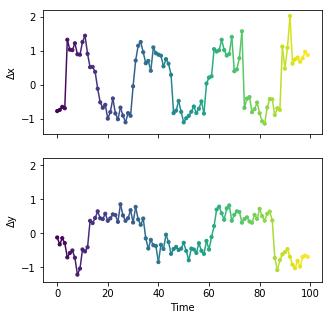

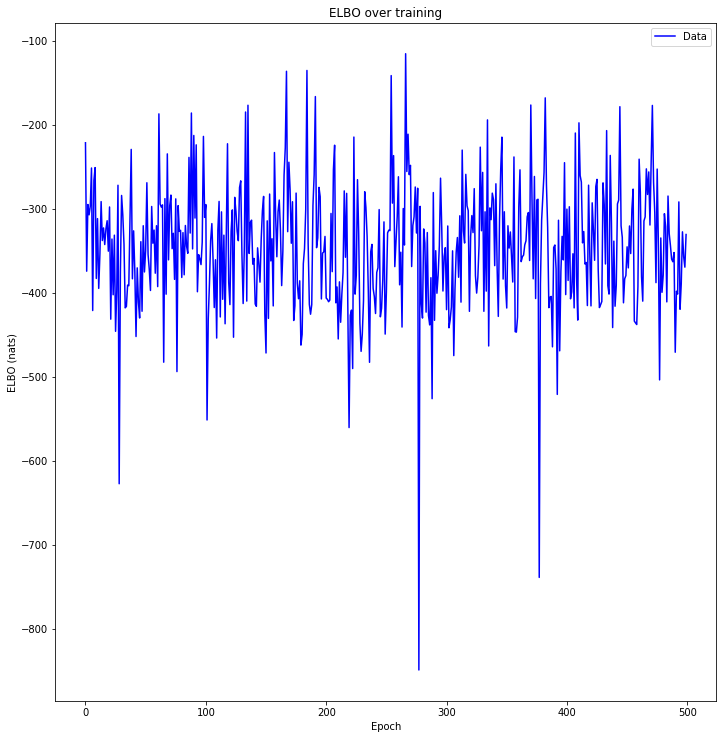

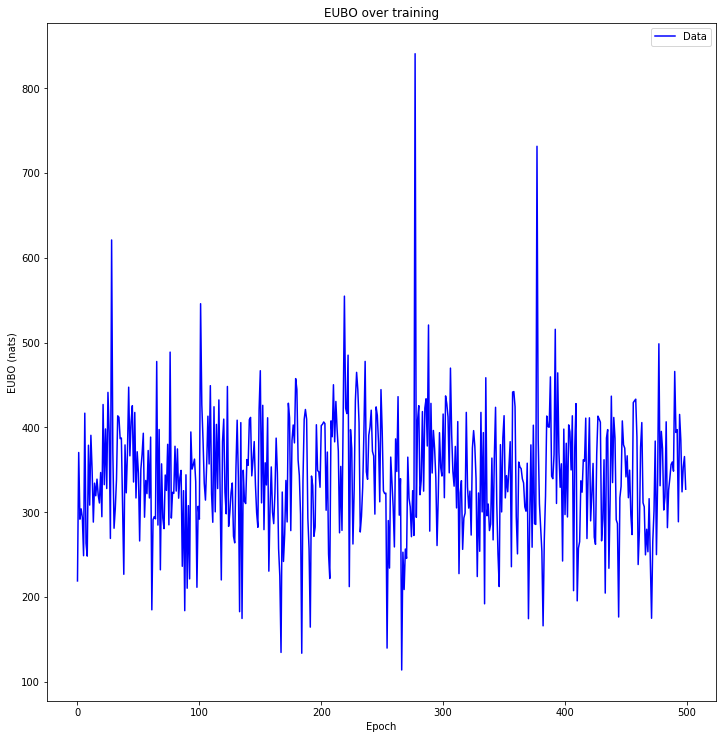

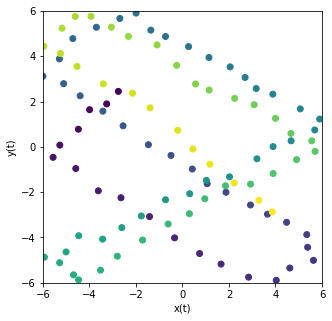

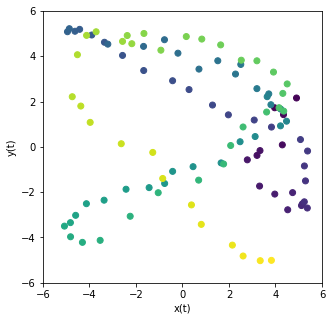

03/05/2019 15:39:17 MSE at time 0: tensor(45.7084)
03/05/2019 15:39:17 MSE at time 1: tensor(66.7239)
03/05/2019 15:39:17 MSE at time 2: tensor(69.5908)
03/05/2019 15:39:17 MSE at time 3: tensor(77.4277)
03/05/2019 15:39:17 MSE at time 4: tensor(72.1258)
03/05/2019 15:39:17 MSE at time 5: tensor(79.2797)
03/05/2019 15:39:17 MSE at time 6: tensor(54.5903)
03/05/2019 15:39:17 MSE at time 7: tensor(48.1568)
03/05/2019 15:39:17 MSE at time 8: tensor(43.7905)
03/05/2019 15:39:17 MSE at time 9: tensor(35.4078)
03/05/2019 15:39:17 MSE at time 10: tensor(29.7560)
03/05/2019 15:39:17 MSE at time 11: tensor(23.6929)
03/05/2019 15:39:17 MSE at time 12: tensor(19.3172)
03/05/2019 15:39:17 MSE at time 13: tensor(15.6920)
03/05/2019 15:39:17 MSE at time 14: tensor(13.4662)
03/05/2019 15:39:17 MSE at time 15: tensor(15.2531)
03/05/2019 15:39:17 MSE at time 16: tensor(17.5199)
03/05/2019 15:39:17 MSE at time 17: tensor(18.0608)
03/05/2019 15:39:17 MSE at time 18: tensor(17.6822)
03/05/2019 15:39:17 MS

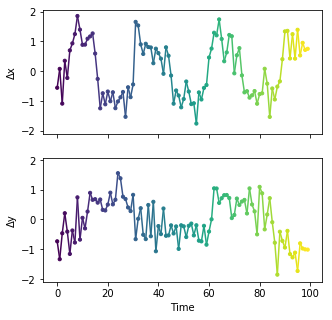

In [24]:
results_dict = experiment()

In [25]:
torch.save(results_dict, 'examples/dynamical_ball/experiment_results.data')